# MRI-to-CT and CT-to-MRI Translation Using CycleGAN
# Date: May 2025

# This notebook implements a medical image translation system using CycleGAN for converting between MRI and CT image modalities.

In [41]:
!pip install monai

In [42]:
# Kaggle-specific setup
import os
if 'KAGGLE_URL_BASE' in os.environ:
    print("Running on Kaggle")
    # Disable internet if not needed
    os.environ["WANDB_DISABLED"] = "true"

Running on Kaggle


In [43]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [44]:
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

In [45]:
import torch, os, subprocess, textwrap
print("CUDA available:", torch.cuda.is_available(), "| device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi -L

CUDA available: True | device: Tesla T4
GPU 0: Tesla T4 (UUID: GPU-1ae42d18-90e8-85fd-627e-66be8316475f)
GPU 1: Tesla T4 (UUID: GPU-46aa7fbb-28f5-08fb-fc46-3b35f1c98f48)


In [46]:
# Import MONAI for medical imaging specific tools
from monai.transforms import (
    EnsureChannelFirst,LoadImage, ScaleIntensity, Resize, 
    RandRotate, RandFlip, RandZoom, Compose, NormalizeIntensity, Lambda
)
from monai.data import ImageDataset
from monai.visualize import plot_2d_or_3d_image
from monai.networks.blocks import ResidualUnit
from monai.metrics import SSIMMetric, PSNRMetric

In [47]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [48]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# 1. Data Loading and Preprocessing
# ================================

In [49]:
# ============================================================================
# Data Loading and Preprocessing
# ============================================================================

BASE_PATH = "/kaggle/input/ct-to-mri-cgan/Dataset"

# Note: trainA = CT, trainB = MRI (CycleGAN convention)
CT_TRAIN_PATH = f"{BASE_PATH}/images/trainA"
MRI_TRAIN_PATH = f"{BASE_PATH}/images/trainB"
CT_VAL_PATH = f"{BASE_PATH}/images/testA"
MRI_VAL_PATH = f"{BASE_PATH}/images/testB"

# No separate test paths - use validation for testing
CT_TEST_PATH = CT_VAL_PATH
MRI_TEST_PATH = MRI_VAL_PATH

def count_files(p):
    """Count image files (png, jpg, jpeg)"""
    valid_ext = ('.png', '.jpg', '.jpeg')
    return len([f for f in os.listdir(p) if f.lower().endswith(valid_ext)])

len_ct = count_files(CT_TRAIN_PATH)
len_mri = count_files(MRI_TRAIN_PATH)
MAX_ITEMS_PER_EPOCH = max(len_ct, len_mri)
VAL_ITEMS_PER_EPOCH = min(1000, MAX_ITEMS_PER_EPOCH // 4)

print(f"Dataset Statistics:")
print(f"CT training images: {len_ct}")
print(f"MRI training images: {len_mri}")
print(f"CT validation images: {count_files(CT_VAL_PATH)}")
print(f"MRI validation images: {count_files(MRI_VAL_PATH)}")

Dataset Statistics:
CT training images: 1742
MRI training images: 1744
CT validation images: 744
MRI validation images: 744


In [50]:
# Helper function to list image files in directory
def list_images_in_dir(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".npy")]
    return files

In [51]:
def load_npy_file(file_path):
    return np.load(file_path)

In [52]:
from PIL import Image
import numpy as np

def get_transforms(mode="train", modality="mri", target_size=(256, 256)):
    """
    Handle RGB MRIs and grayscale CTs
    """
    
    def load_and_preprocess(file_path):
        """Load image and convert to grayscale"""
        img = Image.open(file_path).convert('L')  # Force grayscale
        img_array = np.array(img, dtype=np.float32)
        img_array = img_array[np.newaxis, ...]  # Add channel: [H,W] -> [1,H,W]
        return img_array
    
    common_transforms = [
        Lambda(func=load_and_preprocess),
        Resize(spatial_size=target_size, mode="bilinear"),
        ScaleIntensity(minv=-1.0, maxv=1.0)
    ]
    
    if mode == "train":
        return Compose([
            *common_transforms,
            RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
            RandFlip(spatial_axis=1, prob=0.5),
            RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ])
    else:
        return Compose(common_transforms)

In [53]:
import random

class UnpairedDataset(Dataset):
    def __init__(self, source_dir, target_dir, source_transform=None, 
                 target_transform=None, max_items_per_epoch=None):
        valid_ext = ('.png', '.jpg', '.jpeg')
        
        self.source_files = sorted([
            os.path.join(source_dir, f) 
            for f in os.listdir(source_dir) 
            if f.lower().endswith(valid_ext)
        ])
        
        self.target_files = sorted([
            os.path.join(target_dir, f) 
            for f in os.listdir(target_dir) 
            if f.lower().endswith(valid_ext)
        ])
        
        self.source_transform = source_transform
        self.target_transform = target_transform
        self.max_items_per_epoch = max_items_per_epoch
        
        print(f"Loaded {len(self.source_files)} source images")
        print(f"Loaded {len(self.target_files)} target images")

    def __len__(self):
        return self.max_items_per_epoch or max(len(self.source_files), 
                                               len(self.target_files))

    def __getitem__(self, idx):
        # Source: cycle through with modulo
        s = self.source_files[idx % len(self.source_files)]
        
        # Target: RANDOMIZE to prevent discriminator memorization
        t = self.target_files[random.randint(0, len(self.target_files) - 1)]
        
        # Apply transforms
        xs = self.source_transform(s) if self.source_transform else s
        xt = self.target_transform(t) if self.target_transform else t
        
        # Ensure tensors have correct shape [C, H, W]
        if xs.dim() == 2:
            xs = xs.unsqueeze(0)
        if xt.dim() == 2:
            xt = xt.unsqueeze(0)
        
        # Handle RGB to grayscale conversion if needed
        if xs.shape[0] == 3:
            xs = xs.mean(dim=0, keepdim=True)
        if xt.shape[0] == 3:
            xt = xt.mean(dim=0, keepdim=True)
        
        return {"source": xs, "target": xt}

In [54]:
def create_dataloaders(batch_size=8, target_size=(256, 256)):
    """
    Create dataloaders with separate transforms for MRI and CT
    """
    # MRI = trainB, CT = trainA
    mri_train_transform = get_transforms(mode="train", modality="mri", target_size=target_size)
    ct_train_transform = get_transforms(mode="train", modality="ct", target_size=target_size)
    
    mri_val_transform = get_transforms(mode="val", modality="mri", target_size=target_size)
    ct_val_transform = get_transforms(mode="val", modality="ct", target_size=target_size)

    train_ds = UnpairedDataset(
        MRI_TRAIN_PATH,  # trainB (MRI)
        CT_TRAIN_PATH,   # trainA (CT)
        source_transform=mri_train_transform,
        target_transform=ct_train_transform,
        max_items_per_epoch=MAX_ITEMS_PER_EPOCH
    )
    
    val_ds = UnpairedDataset(
        MRI_VAL_PATH,    # testB (MRI)
        CT_VAL_PATH,     # testA (CT)
        source_transform=mri_val_transform,
        target_transform=ct_val_transform,
        max_items_per_epoch=VAL_ITEMS_PER_EPOCH
    )

    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=4, 
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
    
    val_loader = DataLoader(
        val_ds, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4, 
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
    
    return train_loader, val_loader

In [55]:
def inspect_ct_images(ct_dir, num_samples=5):
    """
    Inspect CT images to check if they're mixed brain/bone window
    """
    import matplotlib.pyplot as plt
    
    ct_files = [f for f in os.listdir(ct_dir) 
                if f.lower().endswith(('.png', '.jpg'))][:num_samples]
    
    fig, axes = plt.subplots(1, len(ct_files), figsize=(4*len(ct_files), 4))
    if len(ct_files) == 1:
        axes = [axes]
    
    for ax, fname in zip(axes, ct_files):
        img_path = os.path.join(ct_dir, fname)
        img = plt.imread(img_path)
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{fname}\nMean: {img.mean():.2f}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig("ct_inspection.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("CT inspection saved to: ct_inspection.png")
    print("\nCheck if images are:")
    print("  - Mostly gray (brain window) → Good")
    print("  - Mix of white skulls + gray brains → Model might struggle")

# Run before training
inspect_ct_images(CT_TRAIN_PATH)

CT inspection saved to: ct_inspection.png

Check if images are:
  - Mostly gray (brain window) → Good
  - Mix of white skulls + gray brains → Model might struggle


In [56]:
def diagnose_dataset_channels(data_dir, num_samples=10):
    """Check channel dimensions of images in directory"""
    from PIL import Image
    import os
    
    files = [f for f in os.listdir(data_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    
    print(f"\nDiagnosing {data_dir}")
    print("="*60)
    
    channel_counts = {}
    for fname in files:
        img_path = os.path.join(data_dir, fname)
        img = Image.open(img_path)
        
        mode = img.mode
        shape = np.array(img).shape
        
        if mode not in channel_counts:
            channel_counts[mode] = 0
        channel_counts[mode] += 1
        
        print(f"{fname:30s} | Mode: {mode:5s} | Shape: {shape}")
    
    print("\nSummary:")
    for mode, count in channel_counts.items():
        print(f"  {mode}: {count} images")
    print("="*60)

# Run diagnostics
print("Checking MRI training data:")
diagnose_dataset_channels(MRI_TRAIN_PATH)

print("\nChecking CT training data:")
diagnose_dataset_channels(CT_TRAIN_PATH)

Checking MRI training data:

Diagnosing /kaggle/input/ct-to-mri-cgan/Dataset/images/trainB
mri1265.jpg                    | Mode: RGB   | Shape: (225, 225, 3)
mri646.jpg                     | Mode: RGB   | Shape: (168, 300, 3)
mri766.jpg                     | Mode: RGB   | Shape: (417, 428, 3)
mri1245.jpg                    | Mode: RGB   | Shape: (449, 359, 3)
mri343.jpg                     | Mode: RGB   | Shape: (512, 512, 3)
mri896.jpg                     | Mode: RGB   | Shape: (222, 227, 3)
mri1897.jpg                    | Mode: RGB   | Shape: (217, 232, 3)
mri444.jpg                     | Mode: RGB   | Shape: (512, 512, 3)
mri902.jpg                     | Mode: RGB   | Shape: (221, 228, 3)
mri1905.jpg                    | Mode: RGB   | Shape: (197, 177, 3)

Summary:
  RGB: 10 images

Checking CT training data:

Diagnosing /kaggle/input/ct-to-mri-cgan/Dataset/images/trainA
ct1857.png                     | Mode: L     | Shape: (512, 512)
ct1151.png                     | Mode: L     |

# 2. Model Architecture
# ====================

In [57]:
# Define the Generator (U-Net with residual blocks)
class ResUNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(ResUNetGenerator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=7, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling
        self.down1 = self._downsample(features, features * 2)
        self.down2 = self._downsample(features * 2, features * 4)
        
        # Residual blocks
        self.res_blocks = nn.Sequential(
            ResidualUnit(
                spatial_dims=2,
                in_channels=features * 4,
                out_channels=features * 4,
                strides=1,
                kernel_size=3,
                subunits=6,  # Number of residual blocks
                act="RELU",
                norm="INSTANCE",
                dropout=0.0
            )
        )
        
        # Upsampling
        self.up1 = self._upsample(features * 4, features * 2)
        self.up2 = self._upsample(features * 2, features)
        
        # Output layer
        self.output = nn.Sequential(
            nn.Conv2d(features, out_channels, kernel_size=7, padding=3, padding_mode="reflect"),
            nn.Tanh()
        )
    
    def _downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.res_blocks(x)
        x = self.up1(x)
        x = self.up2(x)
        return self.output(x)

In [58]:
# Define the Discriminator (PatchGAN)
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        super(PatchDiscriminator, self).__init__()
        
        # Using spectral normalization for stability
        self.disc = nn.Sequential(
            # Layer 1: no normalization
            nn.utils.spectral_norm(nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            nn.utils.spectral_norm(nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            nn.utils.spectral_norm(nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4
            nn.utils.spectral_norm(nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=1, padding=1)),
            nn.InstanceNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.disc(x)

# 3. CycleGAN Implementation
# =========================

In [59]:
class CycleGAN:
    def __init__(self, lr=0.0002, lambda_cycle=10.0, lambda_identity=0.5):
        # Generators
        self.G_MRI_to_CT = ResUNetGenerator().to(device)
        self.G_CT_to_MRI = ResUNetGenerator().to(device)

        if torch.cuda.device_count() > 1:
            print(f"Let's use {torch.cuda.device_count()} GPUs!")
            self.G_MRI_to_CT = nn.DataParallel(self.G_MRI_to_CT)
            self.G_CT_to_MRI = nn.DataParallel(self.G_CT_to_MRI)
        
        # Discriminators
        self.D_MRI = PatchDiscriminator().to(device)
        self.D_CT = PatchDiscriminator().to(device)
        
        # Optimizers
        self.opt_generators = optim.Adam(
            list(self.G_MRI_to_CT.parameters()) + list(self.G_CT_to_MRI.parameters()),
            lr=lr,
            betas=(0.5, 0.999)
        )
        
        self.opt_discriminators = optim.Adam(
            list(self.D_MRI.parameters()) + list(self.D_CT.parameters()),
            lr=lr,
            betas=(0.5, 0.999)
        )
        
        # Learning rate schedulers
        self.scheduler_G = optim.lr_scheduler.CosineAnnealingLR(self.opt_generators, T_max=50)
        self.scheduler_D = optim.lr_scheduler.CosineAnnealingLR(self.opt_discriminators, T_max=50)
        
        # Loss functions
        self.criterion_gan = nn.MSELoss()  # LSGAN loss for stability
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()
        
        # SSIM loss for structural similarity
        self.criterion_ssim = SSIMMetric(spatial_dims=2)
        
        # Loss weights
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.lambda_ssim = 1.0  # Weight for SSIM loss

        # --- AMP setup ---
        self.use_amp = torch.cuda.is_available()
        self.scaler_G = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.scaler_D = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        
        # Tracking metrics
        self.train_history = {
            'D_loss': [], 'G_loss': [], 'cycle_loss': [], 'identity_loss': [],
            'ssim_loss': [], 'total_loss': []
        }
        self.val_history = {
            'ssim': [], 'psnr': []
        }
        
    def set_requires_grad(self, nets, requires_grad=True):
        """Set requies_grad for all the networks to avoid unnecessary computations"""
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
    
    def train_step(self, batch):
        real_mri = batch["source"].to(device)
        real_ct  = batch["target"].to(device)
    
        # ==========================
        # GENERATORS (update G only)
        # ==========================
        self.set_requires_grad([self.D_MRI, self.D_CT], False)
        self.opt_generators.zero_grad(set_to_none=True)
    
        with torch.amp.autocast('cuda', enabled=self.use_amp):
            # Forward
            fake_ct   = self.G_MRI_to_CT(real_mri)
            cycle_mri = self.G_CT_to_MRI(fake_ct)
    
            fake_mri  = self.G_CT_to_MRI(real_ct)
            cycle_ct  = self.G_MRI_to_CT(fake_mri)
    
            # Identity
            identity_mri = self.G_CT_to_MRI(real_mri)
            identity_ct  = self.G_MRI_to_CT(real_ct)
    
            # GAN losses
            D_fake_ct  = self.D_CT(fake_ct)
            D_fake_mri = self.D_MRI(fake_mri)
            loss_G = self.criterion_gan(D_fake_ct,  torch.ones_like(D_fake_ct)) + \
                     self.criterion_gan(D_fake_mri, torch.ones_like(D_fake_mri))
    
            # Cycle, identity, SSIM
            loss_cycle    = self.criterion_cycle(cycle_mri, real_mri) + self.criterion_cycle(cycle_ct, real_ct)
            loss_identity = self.criterion_identity(identity_mri, real_mri) + self.criterion_identity(identity_ct, real_ct)
    
            # SSIM returns higher-is-better; use (1 - ssim).mean() for both directions
            loss_ssim = (1 - self.criterion_ssim(cycle_mri, real_mri)).mean() + \
                        (1 - self.criterion_ssim(cycle_ct,  real_ct)).mean()
    
            loss_G_total = loss_G + \
                           self.lambda_cycle   * loss_cycle + \
                           self.lambda_identity* loss_identity + \
                           self.lambda_ssim    * loss_ssim
    
        self.scaler_G.scale(loss_G_total).backward()
        self.scaler_G.step(self.opt_generators)
        self.scaler_G.update()
    
        # ==========================
        # DISCRIMINATORS (update D)
        # ==========================
        self.set_requires_grad([self.D_MRI, self.D_CT], True)
        self.opt_discriminators.zero_grad(set_to_none=True)
    
        with torch.amp.autocast('cuda', enabled=self.use_amp):
            # MRI D
            D_real_mri = self.D_MRI(real_mri)
            D_fake_mri = self.D_MRI(fake_mri.detach())
            loss_D_MRI = 0.5 * (
                self.criterion_gan(D_real_mri, torch.ones_like(D_real_mri)) +
                self.criterion_gan(D_fake_mri, torch.zeros_like(D_fake_mri))
            )
    
            # CT D
            D_real_ct = self.D_CT(real_ct)
            D_fake_ct = self.D_CT(fake_ct.detach())
            loss_D_CT = 0.5 * (
                self.criterion_gan(D_real_ct, torch.ones_like(D_real_ct)) +
                self.criterion_gan(D_fake_ct, torch.zeros_like(D_fake_ct))
            )
    
            loss_D_total = loss_D_MRI + loss_D_CT
    
        self.scaler_D.scale(loss_D_total).backward()
        self.scaler_D.step(self.opt_discriminators)
        self.scaler_D.update()
    
        # ----- logging -----
        self.train_history['D_loss'].append(loss_D_total.item())
        self.train_history['G_loss'].append(loss_G.item())
        self.train_history['cycle_loss'].append(loss_cycle.item())
        self.train_history['identity_loss'].append(loss_identity.item())
        self.train_history['ssim_loss'].append(loss_ssim.item())
        self.train_history['total_loss'].append(loss_G_total.item())
    
        return {
            'D_loss': loss_D_total.item(),
            'G_loss': loss_G.item(),
            'cycle_loss': loss_cycle.item(),
            'identity_loss': loss_identity.item(),
            'ssim_loss': loss_ssim.item(),
            'total_loss': loss_G_total.item(),
            'images': {
                'real_mri': real_mri,
                'fake_ct': fake_ct,
                'cycle_mri': cycle_mri,
                'real_ct': real_ct,
                'fake_mri': fake_mri,
                'cycle_ct': cycle_ct
            }
        }

        
    def validate(self, val_loader):
        """Run validation and compute metrics."""
        self.G_MRI_to_CT.eval()
        self.G_CT_to_MRI.eval()
        self.D_MRI.eval()
        self.D_CT.eval()
        
        ssim_metric = SSIMMetric(spatial_dims=2)
        psnr_metric = PSNRMetric(max_val=2.0)
        
        val_ssim_mri = 0.0
        val_ssim_ct = 0.0
        val_psnr_mri = 0.0
        val_psnr_ct = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                real_mri = batch["source"].to(device)
                real_ct = batch["target"].to(device)
                
                # Generate fake images
                fake_ct = self.G_MRI_to_CT(real_mri)
                fake_mri = self.G_CT_to_MRI(real_ct)
                
                # Reconstruct original images
                cycle_mri = self.G_CT_to_MRI(fake_ct)
                cycle_ct = self.G_MRI_to_CT(fake_mri)
                
                # Compute SSIM (higher is better)
                ssim_mri = ssim_metric(cycle_mri, real_mri)
                ssim_ct = ssim_metric(cycle_ct, real_ct)
                
                # Compute PSNR (higher is better)
                psnr_mri = psnr_metric(cycle_mri, real_mri)
                psnr_ct = psnr_metric(cycle_ct, real_ct)
                
                val_ssim_mri += ssim_mri.mean().item()
                val_ssim_ct += ssim_ct.mean().item()
                val_psnr_mri += psnr_mri.mean().item()
                val_psnr_ct += psnr_ct.mean().item()
                
                num_batches += 1
        
        # Calculate average metrics
        avg_ssim = (val_ssim_mri + val_ssim_ct) / (2 * num_batches)
        avg_psnr = (val_psnr_mri + val_psnr_ct) / (2 * num_batches)
        
        self.val_history['ssim'].append(avg_ssim)
        self.val_history['psnr'].append(avg_psnr)
        
        # Set models back to training mode
        self.G_MRI_to_CT.train()
        self.G_CT_to_MRI.train()
        self.D_MRI.train()
        self.D_CT.train()
        
        return {
            'ssim': avg_ssim,
            'psnr': avg_psnr,
            'example_images': {
                'real_mri': real_mri,
                'fake_ct': fake_ct,
                'cycle_mri': cycle_mri,
                'real_ct': real_ct,
                'fake_mri': fake_mri,
                'cycle_ct': cycle_ct
            }
        }
    
    def save_models(self, save_dir):
        """Save model weights"""
        os.makedirs(save_dir, exist_ok=True)
        
        torch.save(self.G_MRI_to_CT.state_dict(), os.path.join(save_dir, 'G_MRI_to_CT.pth'))
        torch.save(self.G_CT_to_MRI.state_dict(), os.path.join(save_dir, 'G_CT_to_MRI.pth'))
        torch.save(self.D_MRI.state_dict(), os.path.join(save_dir, 'D_MRI.pth'))
        torch.save(self.D_CT.state_dict(), os.path.join(save_dir, 'D_CT.pth'))
        
        print(f"Model weights saved to {save_dir}")
    
    def load_models(self, load_dir):
        """Load model weights"""
        self.G_MRI_to_CT.load_state_dict(torch.load(os.path.join(load_dir, 'G_MRI_to_CT.pth')))
        self.G_CT_to_MRI.load_state_dict(torch.load(os.path.join(load_dir, 'G_CT_to_MRI.pth')))
        self.D_MRI.load_state_dict(torch.load(os.path.join(load_dir, 'D_MRI.pth')))
        self.D_CT.load_state_dict(torch.load(os.path.join(load_dir, 'D_CT.pth')))
        
        print(f"Model weights loaded from {load_dir}")

# 4. Training Loop
# ===============

In [73]:
def train(model, train_loader, val_loader, num_epochs=200, save_dir="./checkpoints", 
          save_interval=10, plot_interval=5, validate_every=5, resume_checkpoint=None):
    """Train the CycleGAN model"""
    os.makedirs(save_dir, exist_ok=True)
    
    start_epoch = 0
    best_ssim = 0.0

    if resume_checkpoint and os.path.exists(resume_checkpoint):
        start_epoch, best_ssim = load_training_checkpoint(model, resume_checkpoint)
    
    start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        epoch_start = time.time()
        running_results = {
            'D_loss': 0.0, 'G_loss': 0.0, 'cycle_loss': 0.0,
            'identity_loss': 0.0, 'ssim_loss': 0.0, 'total_loss': 0.0
        }
        
        # Training phase
        model.G_MRI_to_CT.train()
        model.G_CT_to_MRI.train()
        model.D_MRI.train()
        model.D_CT.train()
        
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for i, batch in enumerate(train_loader):
                results = model.train_step(batch)
                
                # Update running results
                for k in running_results:
                    if k in results:
                        running_results[k] += results[k]
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix(**{k: v / (i + 1) for k, v in running_results.items()})

                # Clear CUDA cache periodically to prevent fragmentation
                if (i + 1) % 100 == 0:
                    torch.cuda.empty_cache()
                    
                # Visualize images periodically
                if i == 0:
                    images = results['images']
                    visualize_results(images, epoch, i)
        
        # Validation phase - only run every N epochs
        if (epoch + 1) % validate_every == 0 or epoch == 0:
            val_results = model.validate(val_loader)
            print(f"Validation - SSIM: {val_results['ssim']:.4f}, PSNR: {val_results['psnr']:.4f}")
            
            # Save best model (move this inside the validation block)
            if val_results['ssim'] > best_ssim:
                best_ssim = val_results['ssim']
                model.save_models(os.path.join(save_dir, 'best_model'))
                print(f"New best model saved with SSIM: {best_ssim:.4f}")
        else:
            # Skip validation but still update progress
            print(f"Epoch {epoch+1} completed - validation skipped (next at epoch {epoch+1+(validate_every-(epoch+1)%validate_every)})")
        
        
        # Save model periodically
        if (epoch + 1) % save_interval == 0:
            # Save model weights (lighter)
            model.save_models(os.path.join(save_dir, f'epoch_{epoch+1}'))
            
            # Save complete checkpoint for resumption (includes optimizers)
            checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
            save_training_checkpoint(model, epoch, checkpoint_path)
        
        # Plot training history
        if (epoch + 1) % plot_interval == 0:
            plot_training_history(model.train_history, model.val_history)
        
        # Update learning rate schedulers
        model.scheduler_G.step()
        model.scheduler_D.step()
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s. "
              f"Total time: {(time.time()-start_time)/60:.2f}m")
    
    print(f"Training completed in {(time.time()-start_time)/60:.2f} minutes")
    return model

# 5. Visualization and Evaluation
# ==============================

In [61]:
def visualize_results(images, epoch, batch_idx):
    """Visualize translation results"""
    os.makedirs("results", exist_ok=True)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert images to numpy and scale to [0, 1]
    def convert_for_display(img):
        return img.detach().cpu().numpy()[0, 0].clip(-1, 1) * 0.5 + 0.5
    
    # First row: MRI -> CT -> MRI
    axs[0, 0].imshow(convert_for_display(images['real_mri']), cmap='gray')
    axs[0, 0].set_title("Real MRI")
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(convert_for_display(images['fake_ct']), cmap='gray')
    axs[0, 1].set_title("Fake CT (from MRI)")
    axs[0, 1].axis('off')
    
    axs[0, 2].imshow(convert_for_display(images['cycle_mri']), cmap='gray')
    axs[0, 2].set_title("Reconstructed MRI")
    axs[0, 2].axis('off')
    
    # Second row: CT -> MRI -> CT
    axs[1, 0].imshow(convert_for_display(images['real_ct']), cmap='gray')
    axs[1, 0].set_title("Real CT")
    axs[1, 0].axis('off')
    
    axs[1, 1].imshow(convert_for_display(images['fake_mri']), cmap='gray')
    axs[1, 1].set_title("Fake MRI (from CT)")
    axs[1, 1].axis('off')
    
    axs[1, 2].imshow(convert_for_display(images['cycle_ct']), cmap='gray')
    axs[1, 2].set_title("Reconstructed CT")
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"results/epoch_{epoch+1}_batch_{batch_idx}.png")
    plt.close()

In [62]:
def plot_training_history(train_history, val_history):
    """Plot training and validation metrics history"""
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot generator and discriminator losses
    axs[0, 0].plot(train_history['G_loss'], label='Generator')
    axs[0, 0].plot(train_history['D_loss'], label='Discriminator')
    axs[0, 0].set_title('Adversarial Losses')
    axs[0, 0].set_xlabel('Iterations')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # Plot cycle and identity losses
    axs[0, 1].plot(train_history['cycle_loss'], label='Cycle')
    axs[0, 1].plot(train_history['identity_loss'], label='Identity')
    axs[0, 1].plot(train_history['ssim_loss'], label='SSIM')
    axs[0, 1].set_title('Cycle and Identity Losses')
    axs[0, 1].set_xlabel('Iterations')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Plot total loss
    axs[1, 0].plot(train_history['total_loss'])
    axs[1, 0].set_title('Total Generator Loss')
    axs[1, 0].set_xlabel('Iterations')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].grid(True)
    
    # Plot validation metrics
    if len(val_history['ssim']) > 0:
        epochs = range(1, len(val_history['ssim'])+1)
        axs[1, 1].plot(epochs, val_history['ssim'], 'b-o', label='SSIM')
        ax2 = axs[1, 1].twinx()
        ax2.plot(epochs, val_history['psnr'], 'r-o', label='PSNR')
        axs[1, 1].set_title('Validation Metrics')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('SSIM', color='b')
        ax2.set_ylabel('PSNR (dB)', color='r')
        axs[1, 1].legend(loc='upper left')
        ax2.legend(loc='upper right')
        axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"results/training_history.png")
    plt.close()

In [63]:
def validate_data_quality(loader):
    """Comprehensive data quality check"""
    batch = next(iter(loader))
    mri = batch["source"]
    ct = batch["target"]
    
    print("\n" + "="*70)
    print("DATA QUALITY CHECK")
    print("="*70)
    print(f"Batch size: {mri.shape[0]}")
    print(f"Image dimensions: {mri.shape[2:]}") 
    print(f"\nMRI Statistics:")
    print(f"  Shape: {mri.shape}")
    print(f"  Range: [{mri.min():.3f}, {mri.max():.3f}]")
    print(f"  Mean: {mri.mean():.3f}, Std: {mri.std():.3f}")
    
    print(f"\nCT Statistics:")
    print(f"  Shape: {ct.shape}")
    print(f"  Range: [{ct.min():.3f}, {ct.max():.3f}]")
    print(f"  Mean: {ct.mean():.3f}, Std: {ct.std():.3f}")
    
    # Check for issues
    warnings = []
    if mri.std() < 0.01:
        warnings.append("⚠️  Very low variance in MRI data")
    if ct.std() < 0.01:
        warnings.append("⚠️  Very low variance in CT data")
    if not (-1.1 <= mri.min() <= -0.9 and 0.9 <= mri.max() <= 1.1):
        warnings.append("⚠️  MRI values outside expected [-1, 1] range")
    if not (-1.1 <= ct.min() <= -0.9 and 0.9 <= ct.max() <= 1.1):
        warnings.append("⚠️  CT values outside expected [-1, 1] range")
    
    if warnings:
        print("\nWarnings:")
        for w in warnings:
            print(f"  {w}")
    else:
        print("\n✓ Data looks good!")
    
    print("="*70 + "\n")
    
    # Visualize sample
    visualize_sample_batch(mri, ct)

def visualize_sample_batch(mri, ct):
    """Visualize first sample from batch"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Convert from [-1, 1] to [0, 1] for display
    mri_img = (mri[0, 0].cpu().numpy() + 1) / 2
    ct_img = (ct[0, 0].cpu().numpy() + 1) / 2
    
    axes[0].imshow(mri_img, cmap='gray')
    axes[0].set_title("Sample MRI")
    axes[0].axis('off')
    
    axes[1].imshow(ct_img, cmap='gray')
    axes[1].set_title("Sample CT")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig("sample_data.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("Sample images saved to: sample_data.png")

# 6. Model Inference and Testing
# ============================

In [64]:
def inference(model, image_path, target_modality="CT", save_path=None):
    """
    Run inference on a single image
    image_path: path to .png/.jpg file
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Determine source modality
    source_modality = "mri" if target_modality.upper() == "CT" else "ct"
    transform = get_transforms(mode="val", modality=source_modality)
    
    # Load and transform image
    try:
        image = transform(image_path)
    except Exception as e:
        print(f"Error loading image: {e}")
        raise
    
    # Ensure correct dimensions
    if image.dim() == 2:
        image = image.unsqueeze(0)
    if image.shape[0] == 3:
        image = image.mean(dim=0, keepdim=True)
    
    image = image.unsqueeze(0).to(device)
    
    model.G_MRI_to_CT.eval()
    model.G_CT_to_MRI.eval()
    
    with torch.no_grad():
        if target_modality.upper() == "CT":
            output = model.G_MRI_to_CT(image)
        else:
            output = model.G_CT_to_MRI(image)
    
    # Convert to displayable format [0, 1]
    input_np = (image.cpu().numpy()[0, 0] + 1) / 2
    output_np = (output.cpu().numpy()[0, 0] + 1) / 2
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_np, cmap='gray')
    axs[0].set_title(f"Input {'MRI' if target_modality=='CT' else 'CT'}")
    axs[0].axis('off')
    
    axs[1].imshow(output_np, cmap='gray')
    axs[1].set_title(f"Generated {target_modality}")
    axs[1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Result saved to {save_path}")
    else:
        plt.show()
    
    plt.close()
    
    return input_np, output_np

In [65]:
def evaluate_model(model, test_loader):
    model.G_MRI_to_CT.eval()
    model.G_CT_to_MRI.eval()
    
    # Initialize metrics
    ssim_metric = SSIMMetric(spatial_dims=2)
    psnr_metric = PSNRMetric(max_val=1.0)  # Match your data's normalization
    
    results = {
        'cycle_mri': {'ssim': [], 'psnr': []},
        'cycle_ct': {'ssim': [], 'psnr': []}
    }
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            real_mri = batch["source"].to(device)
            real_ct = batch["target"].to(device)
            
            # Forward passes
            fake_ct = model.G_MRI_to_CT(real_mri)
            fake_mri = model.G_CT_to_MRI(real_ct)
            cycle_mri = model.G_CT_to_MRI(fake_ct)
            cycle_ct = model.G_MRI_to_CT(fake_mri)
            
            # Compute metrics
            results['cycle_mri']['ssim'].append(ssim_metric(cycle_mri, real_mri).mean().item())
            results['cycle_mri']['psnr'].append(psnr_metric(cycle_mri, real_mri).mean().item())
            
            results['cycle_ct']['ssim'].append(ssim_metric(cycle_ct, real_ct).mean().item())
            results['cycle_ct']['psnr'].append(psnr_metric(cycle_ct, real_ct).mean().item())
    
    # Calculate averages safely
    for modality in results:
        for metric in results[modality]:
            if len(results[modality][metric]) > 0:
                results[modality][metric] = sum(results[modality][metric]) / len(results[modality][metric])
            else:
                results[modality][metric] = 0.0  # Handle empty case
                print(f"Warning: No {metric} data for {modality}")
                
    # Print results
    print("\nEvaluation Results:")
    print("-" * 50)
    print(f"Cycle MRI - SSIM: {results['cycle_mri']['ssim']:.4f}, PSNR: {results['cycle_mri']['psnr']:.4f}")
    print(f"Cycle CT - SSIM: {results['cycle_ct']['ssim']:.4f}, PSNR: {results['cycle_ct']['psnr']:.4f}")
    print("-" * 50)
    
    return results

In [66]:
def save_comparison(real_mri, fake_ct, real_ct, fake_mri, save_path):
    """Save a comparison of real and generated images"""
    # Convert tensors to numpy arrays
    def tensor_to_img(t):
        return t.detach().cpu().numpy()[0].clip(-1, 1) * 0.5 + 0.5
    
    real_mri_np = tensor_to_img(real_mri)
    fake_ct_np = tensor_to_img(fake_ct)
    real_ct_np = tensor_to_img(real_ct)
    fake_mri_np = tensor_to_img(fake_mri)
    
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    axs[0, 0].imshow(real_mri_np, cmap='gray')
    axs[0, 0].set_title("Real MRI")
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(fake_ct_np, cmap='gray')
    axs[0, 1].set_title("Generated CT (from MRI)")
    axs[0, 1].axis('off')
    
    axs[1, 0].imshow(real_ct_np, cmap='gray')
    axs[1, 0].set_title("Real CT")
    axs[1, 0].axis('off')
    
    axs[1, 1].imshow(fake_mri_np, cmap='gray')
    axs[1, 1].set_title("Generated MRI (from CT)")
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# 7. Clinical Feature Preservation Analysis
# =======================================

In [67]:
class AnatomicalSegmentationAnalysis:
    """Analyze how well the model preserves anatomical structures"""
    def __init__(self, segmentation_model=None):
        # This would ideally use a pre-trained segmentation model
        # For this example, we'll use a simplified approach
        self.segmentation_model = segmentation_model
    
    def evaluate(self, real_images, generated_images, structures=None):
        """
        Evaluate how well anatomical structures are preserved
        
        Args:
            real_images: Original images
            generated_images: Generated images (after cycle)
            structures: List of anatomical structures to analyze
        
        Returns:
            Dictionary of evaluation metrics
        """
        # This is a placeholder for the actual implementation
        # In a real scenario, you would:
        # 1. Run segmentation on both real and generated images
        # 2. Compare segmentation masks using Dice coefficient or IoU
        # 3. Analyze specific regions of interest
        
        # Simplified implementation for demonstration
        results = {
            'dice_score': 0.85,  # Placeholder value
            'iou': 0.75,         # Placeholder value
            'structure_preservation': {}
        }
        
        if structures:
            for structure in structures:
                # Simulate structure-specific analysis
                results['structure_preservation'][structure] = {
                    'dice': 0.8 + np.random.rand() * 0.15,
                    'volume_diff_percent': np.random.rand() * 10
                }
        
        return results

# ============

In [68]:
def save_training_checkpoint(model, epoch, save_path):
    """Save complete training state for resumption"""
    checkpoint = {
        'epoch': epoch,
        'G_MRI_to_CT': model.G_MRI_to_CT.state_dict(),
        'G_CT_to_MRI': model.G_CT_to_MRI.state_dict(),
        'D_MRI': model.D_MRI.state_dict(),
        'D_CT': model.D_CT.state_dict(),
        'optimizer_G': model.opt_generators.state_dict(),
        'optimizer_D': model.opt_discriminators.state_dict(),
        'scheduler_G': model.scheduler_G.state_dict(),
        'scheduler_D': model.scheduler_D.state_dict(),
        'train_history': model.train_history,
        'val_history': model.val_history,
        'best_ssim': max(model.val_history['ssim']) if model.val_history['ssim'] else 0.0
    }
    torch.save(checkpoint, save_path)
    print(f"✓ Training checkpoint saved: {save_path}")

def load_training_checkpoint(model, checkpoint_path):
    """Resume training from checkpoint"""
    print(f"\nLoading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    
    model.G_MRI_to_CT.load_state_dict(checkpoint['G_MRI_to_CT'])
    model.G_CT_to_MRI.load_state_dict(checkpoint['G_CT_to_MRI'])
    model.D_MRI.load_state_dict(checkpoint['D_MRI'])
    model.D_CT.load_state_dict(checkpoint['D_CT'])
    
    model.opt_generators.load_state_dict(checkpoint['optimizer_G'])
    model.opt_discriminators.load_state_dict(checkpoint['optimizer_D'])
    model.scheduler_G.load_state_dict(checkpoint['scheduler_G'])
    model.scheduler_D.load_state_dict(checkpoint['scheduler_D'])
    
    model.train_history = checkpoint['train_history']
    model.val_history = checkpoint['val_history']
    
    start_epoch = checkpoint['epoch'] + 1
    best_ssim = checkpoint.get('best_ssim', 0.0)
    
    print(f"✓ Resumed from epoch {checkpoint['epoch']}")
    print(f"✓ Best SSIM so far: {best_ssim:.4f}\n")
    
    return start_epoch, best_ssim

In [69]:
def verify_amp_safety(model, val_loader):
    """Verify mixed precision doesn't degrade medical image quality"""
    print("\n" + "="*70)
    print("VERIFYING MIXED PRECISION SAFETY FOR MEDICAL IMAGING")
    print("="*70)
    
    model.G_MRI_to_CT.eval()
    
    batch = next(iter(val_loader))
    real_mri = batch["source"].to(device)
    
    with torch.no_grad():
        # Generate with AMP (FP16)
        with torch.amp.autocast('cuda', enabled=True):
            fake_ct_fp16 = model.G_MRI_to_CT(real_mri)
        
        # Generate without AMP (FP32)
        with torch.amp.autocast('cuda', enabled=False):
            fake_ct_fp32 = model.G_MRI_to_CT(real_mri)
    
    # Compare outputs
    diff = torch.abs(fake_ct_fp16 - fake_ct_fp32).mean().item()
    max_diff = torch.abs(fake_ct_fp16 - fake_ct_fp32).max().item()
    
    print(f"Average difference (FP16 vs FP32): {diff:.6f}")
    print(f"Maximum difference (FP16 vs FP32): {max_diff:.6f}")
    
    if diff > 0.01:
        print("\n⚠️  WARNING: Significant difference detected!")
        print("   Mixed precision may affect medical image quality")
        print("   Consider disabling AMP by setting use_amp=False in CycleGAN")
    else:
        print("\n✓ PASS: Mixed precision is safe for this model")
        print("   FP16 and FP32 outputs are nearly identical")
    
    print("="*70 + "\n")
    
    model.G_MRI_to_CT.train()
    return diff

# Call this in main() after model initialization:
# verify_amp_safety(model, val_loader)

In [74]:
def main():
    os.makedirs("/kaggle/working/results", exist_ok=True)
    os.makedirs("/kaggle/working/checkpoints", exist_ok=True)
    
    # Hyperparameters
    batch_size = 16  # Increased from 2
    num_epochs = 60
    lr = 0.0002
    target_size = (256, 256)  # Match dataset resolution

    print("="*70)
    print("VALIDATING DATA PATHS")
    print("="*70)
    print(f"MRI train path: {MRI_TRAIN_PATH}")
    print(f"MRI train exists: {os.path.exists(MRI_TRAIN_PATH)}")
    print(f"CT train path: {CT_TRAIN_PATH}")
    print(f"CT train exists: {os.path.exists(CT_TRAIN_PATH)}")
    print(f"MRI train count: {count_files(MRI_TRAIN_PATH)}")
    print(f"CT train count: {count_files(CT_TRAIN_PATH)}")
    print("="*70 + "\n")

    # Create dataloaders
    train_loader, val_loader = create_dataloaders(
        batch_size=batch_size, 
        target_size=target_size
    )
    
    # Validate data quality
    validate_data_quality(train_loader)
    
    # Initialize model
    model = CycleGAN(lr=lr, lambda_cycle=10.0, lambda_identity=0.5)
    
    # Verify mixed precision safety (optional but recommended)
    # Uncomment to run the check:
    verify_amp_safety(model, val_loader)
    
    # Quick architecture check
    batch = next(iter(train_loader))
    print(f"Input shapes - MRI: {batch['source'].shape}, CT: {batch['target'].shape}")
    
    # Check for existing checkpoint to resume from
    resume_path = "./checkpoints/latest_checkpoint.pth"
    if not os.path.exists(resume_path):
        resume_path = None  # Start fresh
        print("\nStarting training from scratch...")
    else:
        print(f"\n{'='*70}")
        print("FOUND EXISTING CHECKPOINT!")
        print(f"{'='*70}")
        print(f"You can resume training by uncommenting the resume_checkpoint line below")
        print(f"{'='*70}\n")
        # Uncomment next line to auto-resume:
        resume_path = "./checkpoints/latest_checkpoint.pth"
        # resume_path = None  # Keep this to start fresh, comment to resume
    
    # Train
    trained_model = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        save_dir="./checkpoints",
        save_interval=10,
        plot_interval=5,
        validate_every=5,  # NEW: validate every 5 epochs
        resume_checkpoint=resume_path  # NEW: resume support
    )
    
    # Evaluate
    print("\n" + "="*70)
    print("FINAL EVALUATION")
    print("="*70)
    evaluation_results = evaluate_model(trained_model, val_loader)
    
    # Test inference on demo images
    demo_mri_dir = f"{BASE_PATH}/unseen_demo_images/mri"
    demo_ct_dir = f"{BASE_PATH}/unseen_demo_images/ct"
    
    if os.path.exists(demo_mri_dir):
        demo_mri_files = [f for f in os.listdir(demo_mri_dir) 
                          if f.lower().endswith(('.jpg', '.png'))]
        if demo_mri_files:
            test_mri = os.path.join(demo_mri_dir, demo_mri_files[0])
            print(f"\nTesting MRI→CT on: {demo_mri_files[0]}")
            try:
                inference(trained_model, test_mri, target_modality="CT", 
                     save_path="results/demo_mri_to_ct.png")
            except Exception as e:
                print(f"Error during MRI→CT inference: {e}")
    
    if os.path.exists(demo_ct_dir):
        demo_ct_files = [f for f in os.listdir(demo_ct_dir) 
                         if f.lower().endswith(('.jpg', '.png'))]
        if demo_ct_files:
            test_ct = os.path.join(demo_ct_dir, demo_ct_files[0])
            print(f"Testing CT→MRI on: {demo_ct_files[0]}")
            try:
                inference(trained_model, test_ct, target_modality="MRI", 
                     save_path="results/demo_ct_to_mri.png")
            except Exception as e:
                print(f"Error during CT→MRI inference: {e}")
    
    # Save final model
    trained_model.save_models("./checkpoints/final_model")
    
    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print(f"Best SSIM: {max(trained_model.val_history['ssim']):.4f}")
    print(f"Final checkpoints saved to: ./checkpoints/final_model/")
    print("="*70)


In [75]:
def test_configuration():
    """Test that all optimizations are applied correctly"""
    print("\n" + "="*70)
    print("TESTING CONFIGURATION")
    print("="*70)
    
    # Create test dataloaders
    test_train_loader, test_val_loader = create_dataloaders(
        batch_size=16, 
        target_size=(256, 256)
    )
    
    # Test batch size
    test_batch = next(iter(test_train_loader))
    actual_batch_size = test_batch['source'].shape[0]
    
    print(f"✓ Batch size - Expected: 16, Got: {actual_batch_size}")
    assert actual_batch_size == 16, f"Batch size not updated! Got {actual_batch_size}"
    
    # Test data shape
    print(f"✓ Image shape - {test_batch['source'].shape}")
    assert test_batch['source'].shape[1] == 1, "Should be grayscale (1 channel)"
    assert test_batch['source'].shape[2:] == (256, 256), "Should be 256x256"
    
    # Test data range
    min_val = test_batch['source'].min().item()
    max_val = test_batch['source'].max().item()
    print(f"✓ Data range - Min: {min_val:.3f}, Max: {max_val:.3f}")
    assert -1.1 <= min_val <= 1.1, f"Data range issue: min={min_val}"
    assert -1.1 <= max_val <= 1.1, f"Data range issue: max={max_val}"
    
    # Test epoch length
    print(f"✓ Epoch length - {len(test_train_loader)} batches")
    print(f"✓ Items per epoch - {MAX_ITEMS_PER_EPOCH}")
    
    print("="*70)
    print("✅ ALL CONFIGURATION TESTS PASSED!")
    print("="*70 + "\n")


In [76]:
# Only run the main function if this script is executed directly
if __name__ == "__main__":
    main()

VALIDATING DATA PATHS
MRI train path: /kaggle/input/ct-to-mri-cgan/Dataset/images/trainB
MRI train exists: True
CT train path: /kaggle/input/ct-to-mri-cgan/Dataset/images/trainA
CT train exists: True
MRI train count: 1744
CT train count: 1742

Loaded 1744 source images
Loaded 1742 target images
Loaded 744 source images
Loaded 744 target images

DATA QUALITY CHECK
Batch size: 16
Image dimensions: torch.Size([256, 256])

MRI Statistics:
  Shape: torch.Size([16, 1, 256, 256])
  Range: [-1.000, 1.000]
  Mean: -0.504, Std: 0.518

CT Statistics:
  Shape: torch.Size([16, 1, 256, 256])
  Range: [-1.000, 1.000]
  Mean: -0.591, Std: 0.659

✓ Data looks good!

Sample images saved to: sample_data.png
Let's use 2 GPUs!

VERIFYING MIXED PRECISION SAFETY FOR MEDICAL IMAGING


/tmp/ipykernel_47/2618985074.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler_G = torch.cuda.amp.GradScaler(enabled=self.use_amp)
/tmp/ipykernel_47/2618985074.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler_D = torch.cuda.amp.GradScaler(enabled=self.use_amp)


Average difference (FP16 vs FP32): 0.000810
Maximum difference (FP16 vs FP32): 0.009826

✓ PASS: Mixed precision is safe for this model
   FP16 and FP32 outputs are nearly identical

Input shapes - MRI: torch.Size([16, 1, 256, 256]), CT: torch.Size([16, 1, 256, 256])

FOUND EXISTING CHECKPOINT!
You can resume training by uncommenting the resume_checkpoint line below


Loading checkpoint from: ./checkpoints/latest_checkpoint.pth
✓ Resumed from epoch 9
✓ Best SSIM so far: 0.7505



Epoch 11/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 11 completed - validation skipped (next at epoch 15)
Epoch 11 completed in 446.03s. Total time: 7.43m


Epoch 12/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 12 completed - validation skipped (next at epoch 15)
Epoch 12 completed in 444.38s. Total time: 14.84m


Epoch 13/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 13 completed - validation skipped (next at epoch 15)
Epoch 13 completed in 444.44s. Total time: 22.25m


Epoch 14/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 14 completed - validation skipped (next at epoch 15)
Epoch 14 completed in 443.39s. Total time: 29.64m


Epoch 15/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.7677, PSNR: 24.5292
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.7677
Epoch 15 completed in 872.06s. Total time: 44.17m


Epoch 16/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 16 completed - validation skipped (next at epoch 20)
Epoch 16 completed in 440.69s. Total time: 51.52m


Epoch 17/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 17 completed - validation skipped (next at epoch 20)
Epoch 17 completed in 441.02s. Total time: 58.87m


Epoch 18/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 18 completed - validation skipped (next at epoch 20)
Epoch 18 completed in 441.32s. Total time: 66.22m


Epoch 19/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 19 completed - validation skipped (next at epoch 20)
Epoch 19 completed in 440.99s. Total time: 73.57m


Epoch 20/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.7696, PSNR: 24.6031
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.7696
Model weights saved to ./checkpoints/epoch_20
✓ Training checkpoint saved: ./checkpoints/latest_checkpoint.pth
Epoch 20 completed in 876.90s. Total time: 88.19m


Epoch 21/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 21 completed - validation skipped (next at epoch 25)
Epoch 21 completed in 440.59s. Total time: 95.53m


Epoch 22/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 22 completed - validation skipped (next at epoch 25)
Epoch 22 completed in 440.76s. Total time: 102.88m


Epoch 23/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 23 completed - validation skipped (next at epoch 25)
Epoch 23 completed in 441.34s. Total time: 110.23m


Epoch 24/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 24 completed - validation skipped (next at epoch 25)
Epoch 24 completed in 440.98s. Total time: 117.58m


Epoch 25/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.7762, PSNR: 24.1373
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.7762
Epoch 25 completed in 872.12s. Total time: 132.12m


Epoch 26/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 26 completed - validation skipped (next at epoch 30)
Epoch 26 completed in 440.55s. Total time: 139.46m


Epoch 27/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 27 completed - validation skipped (next at epoch 30)
Epoch 27 completed in 441.68s. Total time: 146.82m


Epoch 28/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 28 completed - validation skipped (next at epoch 30)
Epoch 28 completed in 440.62s. Total time: 154.16m


Epoch 29/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 29 completed - validation skipped (next at epoch 30)
Epoch 29 completed in 441.04s. Total time: 161.52m


Epoch 30/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.7932, PSNR: 25.2862
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.7932
Model weights saved to ./checkpoints/epoch_30
✓ Training checkpoint saved: ./checkpoints/latest_checkpoint.pth
Epoch 30 completed in 872.34s. Total time: 176.05m


Epoch 31/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 31 completed - validation skipped (next at epoch 35)
Epoch 31 completed in 440.36s. Total time: 183.39m


Epoch 32/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 32 completed - validation skipped (next at epoch 35)
Epoch 32 completed in 441.36s. Total time: 190.75m


Epoch 33/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 33 completed - validation skipped (next at epoch 35)
Epoch 33 completed in 440.99s. Total time: 198.10m


Epoch 34/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 34 completed - validation skipped (next at epoch 35)
Epoch 34 completed in 441.06s. Total time: 205.45m


Epoch 35/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.7969, PSNR: 25.8384
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.7969
Epoch 35 completed in 872.92s. Total time: 220.00m


Epoch 36/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 36 completed - validation skipped (next at epoch 40)
Epoch 36 completed in 441.10s. Total time: 227.35m


Epoch 37/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 37 completed - validation skipped (next at epoch 40)
Epoch 37 completed in 441.38s. Total time: 234.71m


Epoch 38/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 38 completed - validation skipped (next at epoch 40)
Epoch 38 completed in 441.69s. Total time: 242.07m


Epoch 39/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 39 completed - validation skipped (next at epoch 40)
Epoch 39 completed in 440.86s. Total time: 249.42m


Epoch 40/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.8033, PSNR: 26.2659
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.8033
Model weights saved to ./checkpoints/epoch_40
✓ Training checkpoint saved: ./checkpoints/latest_checkpoint.pth
Epoch 40 completed in 872.98s. Total time: 263.97m


Epoch 41/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 41 completed - validation skipped (next at epoch 45)
Epoch 41 completed in 440.78s. Total time: 271.31m


Epoch 42/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 42 completed - validation skipped (next at epoch 45)
Epoch 42 completed in 441.10s. Total time: 278.66m


Epoch 43/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 43 completed - validation skipped (next at epoch 45)
Epoch 43 completed in 441.40s. Total time: 286.02m


Epoch 44/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 44 completed - validation skipped (next at epoch 45)
Epoch 44 completed in 442.32s. Total time: 293.39m


Epoch 45/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.8042, PSNR: 26.5745
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.8042
Epoch 45 completed in 872.87s. Total time: 307.94m


Epoch 46/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 46 completed - validation skipped (next at epoch 50)
Epoch 46 completed in 441.13s. Total time: 315.29m


Epoch 47/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 47 completed - validation skipped (next at epoch 50)
Epoch 47 completed in 441.41s. Total time: 322.65m


Epoch 48/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 48 completed - validation skipped (next at epoch 50)
Epoch 48 completed in 441.42s. Total time: 330.01m


Epoch 49/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 49 completed - validation skipped (next at epoch 50)
Epoch 49 completed in 441.46s. Total time: 337.36m


Epoch 50/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.8063, PSNR: 26.6825
Model weights saved to ./checkpoints/best_model
New best model saved with SSIM: 0.8063
Model weights saved to ./checkpoints/epoch_50
✓ Training checkpoint saved: ./checkpoints/latest_checkpoint.pth
Epoch 50 completed in 879.32s. Total time: 352.02m


Epoch 51/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 51 completed - validation skipped (next at epoch 55)
Epoch 51 completed in 441.53s. Total time: 359.38m


Epoch 52/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 52 completed - validation skipped (next at epoch 55)
Epoch 52 completed in 441.62s. Total time: 366.74m


Epoch 53/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 53 completed - validation skipped (next at epoch 55)
Epoch 53 completed in 441.46s. Total time: 374.10m


Epoch 54/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 54 completed - validation skipped (next at epoch 55)
Epoch 54 completed in 441.26s. Total time: 381.45m


Epoch 55/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.8055, PSNR: 26.6410
Epoch 55 completed in 873.19s. Total time: 396.00m


Epoch 56/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 56 completed - validation skipped (next at epoch 60)
Epoch 56 completed in 442.40s. Total time: 403.38m


Epoch 57/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 57 completed - validation skipped (next at epoch 60)
Epoch 57 completed in 442.08s. Total time: 410.75m


Epoch 58/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 58 completed - validation skipped (next at epoch 60)
Epoch 58 completed in 441.88s. Total time: 418.11m


Epoch 59/60:   0%|          | 0/109 [00:00<?, ?it/s]

Epoch 59 completed - validation skipped (next at epoch 60)
Epoch 59 completed in 441.61s. Total time: 425.47m


Epoch 60/60:   0%|          | 0/109 [00:00<?, ?it/s]

Validation - SSIM: 0.8032, PSNR: 26.6004
Model weights saved to ./checkpoints/epoch_60
✓ Training checkpoint saved: ./checkpoints/latest_checkpoint.pth
Epoch 60 completed in 873.75s. Total time: 440.03m
Training completed in 440.03 minutes

FINAL EVALUATION


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


Evaluation Results:
--------------------------------------------------
Cycle MRI - SSIM: 0.7385, PSNR: 19.4137
Cycle CT - SSIM: 0.8731, PSNR: 21.9158
--------------------------------------------------

Testing MRI→CT on: mri675.jpg
Result saved to results/demo_mri_to_ct.png
Testing CT→MRI on: ct1367.png
Result saved to results/demo_ct_to_mri.png
Model weights saved to ./checkpoints/final_model

TRAINING COMPLETE!
Best SSIM: 0.8063
Final checkpoints saved to: ./checkpoints/final_model/


In [79]:
!ls checkpoints

best_model  epoch_20  epoch_40	epoch_60     latest_checkpoint.pth
epoch_10    epoch_30  epoch_50	final_model


In [78]:
!zip -r model_checkpoints.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/epoch_40/ (stored 0%)
  adding: checkpoints/epoch_40/D_CT.pth (deflated 8%)
  adding: checkpoints/epoch_40/G_MRI_to_CT.pth (deflated 8%)
  adding: checkpoints/epoch_40/D_MRI.pth (deflated 8%)
  adding: checkpoints/epoch_40/G_CT_to_MRI.pth (deflated 8%)
  adding: checkpoints/epoch_20/ (stored 0%)
  adding: checkpoints/epoch_20/D_CT.pth (deflated 8%)
  adding: checkpoints/epoch_20/G_MRI_to_CT.pth (deflated 8%)
  adding: checkpoints/epoch_20/D_MRI.pth (deflated 8%)
  adding: checkpoints/epoch_20/G_CT_to_MRI.pth (deflated 8%)
  adding: checkpoints/best_model/ (stored 0%)
  adding: checkpoints/best_model/D_CT.pth (deflated 8%)
  adding: checkpoints/best_model/G_MRI_to_CT.pth (deflated 8%)
  adding: checkpoints/best_model/D_MRI.pth (deflated 8%)
  adding: checkpoints/best_model/G_CT_to_MRI.pth (deflated 8%)
  adding: checkpoints/epoch_50/ (stored 0%)
  adding: checkpoints/epoch_50/D_CT.pth (deflated 8%)
  adding: checkpoints/epoch_50/G

In [82]:
# Complete backup - Download EVERYTHING from your Kaggle notebook
import os
import shutil
from datetime import datetime

# Create timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
archive_name = f"cyclegan_medical_complete_{timestamp}"

print("="*70)
print("CREATING COMPLETE BACKUP")
print("="*70)

# Create temporary directory for organizing files
backup_dir = f"/kaggle/working/{archive_name}"
os.makedirs(backup_dir, exist_ok=True)

# 1. Copy checkpoints
print("\n📦 Copying checkpoints...")
if os.path.exists("./checkpoints"):
    shutil.copytree("./checkpoints", f"{backup_dir}/checkpoints")
    checkpoint_size = sum(os.path.getsize(os.path.join(dirpath,filename)) 
                         for dirpath, dirnames, filenames in os.walk(f"{backup_dir}/checkpoints") 
                         for filename in filenames) / (1024**3)
    print(f"   ✓ Checkpoints copied ({checkpoint_size:.2f} GB)")
else:
    print("   ⚠️ No checkpoints folder found")

# 2. Copy results (images, plots)
print("\n🖼️  Copying results...")
if os.path.exists("./results"):
    shutil.copytree("./results", f"{backup_dir}/results")
    num_images = len([f for f in os.listdir(f"{backup_dir}/results") if f.endswith('.png')])
    print(f"   ✓ Results copied ({num_images} images)")
else:
    print("   ⚠️ No results folder found")

# 3. Copy the notebook itself
print("\n📓 Copying notebook...")
notebook_files = [f for f in os.listdir("/kaggle/working") if f.endswith('.ipynb')]
for nb in notebook_files:
    shutil.copy(f"/kaggle/working/{nb}", f"{backup_dir}/{nb}")
    print(f"   ✓ Copied {nb}")

# 4. Save training history as text summary
print("\n📊 Creating training summary...")
summary_file = f"{backup_dir}/training_summary.txt"
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("CYCLEGAN MEDICAL IMAGING TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Training completed: {timestamp}\n")
    f.write(f"Total epochs: 60\n")
    f.write(f"Final SSIM: 0.8032\n")
    f.write(f"Final PSNR: 26.60 dB\n")
    f.write(f"Training time: 440 minutes (7.3 hours)\n")
    f.write(f"Batch size: 16\n")
    f.write(f"GPUs used: 2x T4\n")
    f.write("\n" + "="*70 + "\n")
    f.write("CONTENTS OF THIS ARCHIVE\n")
    f.write("="*70 + "\n")
    f.write("checkpoints/\n")
    f.write("  ├── epoch_10/        - Model at epoch 10\n")
    f.write("  ├── epoch_20/        - Model at epoch 20\n")
    f.write("  ├── epoch_30/        - Model at epoch 30\n")
    f.write("  ├── epoch_40/        - Model at epoch 40\n")
    f.write("  ├── epoch_50/        - Model at epoch 50\n")
    f.write("  ├── epoch_60/        - Model at epoch 60 (final)\n")
    f.write("  ├── best_model/      - Best model (highest SSIM)\n")
    f.write("  └── latest_checkpoint.pth - Resume training from here\n")
    f.write("\nresults/\n")
    f.write("  ├── epoch_XX_batch_0.png - Generated images per epoch\n")
    f.write("  └── training_history.png - Loss curves and metrics\n")
    f.write("\n*.ipynb - The notebook with all code\n")
    f.write("\ntraining_summary.txt - This file\n")
    f.write("="*70 + "\n")

print(f"   ✓ Summary saved to training_summary.txt")

# 5. Create the zip archive
print(f"\n🗜️  Creating zip archive...")
shutil.make_archive(f"/kaggle/working/{archive_name}", 'zip', backup_dir)

# Clean up temporary directory
shutil.rmtree(backup_dir)

# Get final size
zip_size = os.path.getsize(f"/kaggle/working/{archive_name}.zip") / (1024**3)

print("\n" + "="*70)
print("✅ BACKUP COMPLETE!")
print("="*70)
print(f"📦 Archive name: {archive_name}.zip")
print(f"📏 Archive size: {zip_size:.2f} GB")
print(f"📍 Location: /kaggle/working/{archive_name}.zip")
print("\n🔽 TO DOWNLOAD:")
print("   1. Click the 📁 folder icon on the left sidebar")
print("   2. Navigate to /kaggle/working/")
print(f"   3. Find '{archive_name}.zip'")
print("   4. Click ⋮ (three dots) → Download")
print("="*70)

# List what's inside (first 30 files)
print("\n📋 Archive contents (preview):")
os.system(f"unzip -l /kaggle/working/{archive_name}.zip | head -30")

CREATING COMPLETE BACKUP

📦 Copying checkpoints...
   ✓ Checkpoints copied (0.58 GB)

🖼️  Copying results...
   ✓ Results copied (53 images)

📓 Copying notebook...

📊 Creating training summary...
   ✓ Summary saved to training_summary.txt

🗜️  Creating zip archive...

✅ BACKUP COMPLETE!
📦 Archive name: cyclegan_medical_complete_20251214_122606.zip
📏 Archive size: 0.56 GB
📍 Location: /kaggle/working/cyclegan_medical_complete_20251214_122606.zip

🔽 TO DOWNLOAD:
   1. Click the 📁 folder icon on the left sidebar
   2. Navigate to /kaggle/working/
   3. Find 'cyclegan_medical_complete_20251214_122606.zip'
   4. Click ⋮ (three dots) → Download

📋 Archive contents (preview):
Archive:  /kaggle/working/cyclegan_medical_complete_20251214_122606.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-12-14 12:18   checkpoints/
        0  2025-12-14 12:18   results/
     1225  2025-12-14 12:26   training_summary.txt
        0  2025-12-14 03:12   checkpoints/best_m

0

🧪 TESTING 2 MRI + 2 CT IMAGES WITH QUALITY METRICS

📦 Loading trained model from checkpoint...
Let's use 2 GPUs!
✓ Loaded best model from ./checkpoints/best_model
✓ Found 744 MRI test images
✓ Found 744 CT test images

📸 Selected MRI images:
   1. mri2058.jpg
   2. mri368.jpg

📸 Selected CT images:
   1. ct229.png
   2. ct1759.png

PROCESSING MRI → CT → MRI

[1/2] Processing mri2058.jpg...


/tmp/ipykernel_47/2618985074.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler_G = torch.cuda.amp.GradScaler(enabled=self.use_amp)
/tmp/ipykernel_47/2618985074.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler_D = torch.cuda.amp.GradScaler(enabled=self.use_amp)


   ✓ SSIM: 0.8511 | PSNR: 28.97 dB
   💾 Saved: MRI_to_CT_test1_ssim0.851_psnr29.0_124711.png

[2/2] Processing mri368.jpg...
   ✓ SSIM: 0.6810 | PSNR: 24.19 dB
   💾 Saved: MRI_to_CT_test2_ssim0.681_psnr24.2_124711.png

PROCESSING CT → MRI → CT

[1/2] Processing ct229.png...
   ✓ SSIM: 0.9262 | PSNR: 29.78 dB
   💾 Saved: CT_to_MRI_test1_ssim0.926_psnr29.8_124712.png

[2/2] Processing ct1759.png...
   ✓ SSIM: 0.9083 | PSNR: 32.60 dB
   💾 Saved: CT_to_MRI_test2_ssim0.908_psnr32.6_124713.png

CREATING SUMMARY REPORT


/tmp/ipykernel_47/2230204110.py:376: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.savefig(summary_filename, dpi=150, bbox_inches='tight')
/tmp/ipykernel_47/2230204110.py:376: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(summary_filename, dpi=150, bbox_inches='tight')


   💾 Saved summary: Test_Summary_Report_20251214_124713.png

📊 DISPLAYING ALL RESULTS

📸 CT_to_MRI_test1_ssim0.926_psnr29.8_124712.png


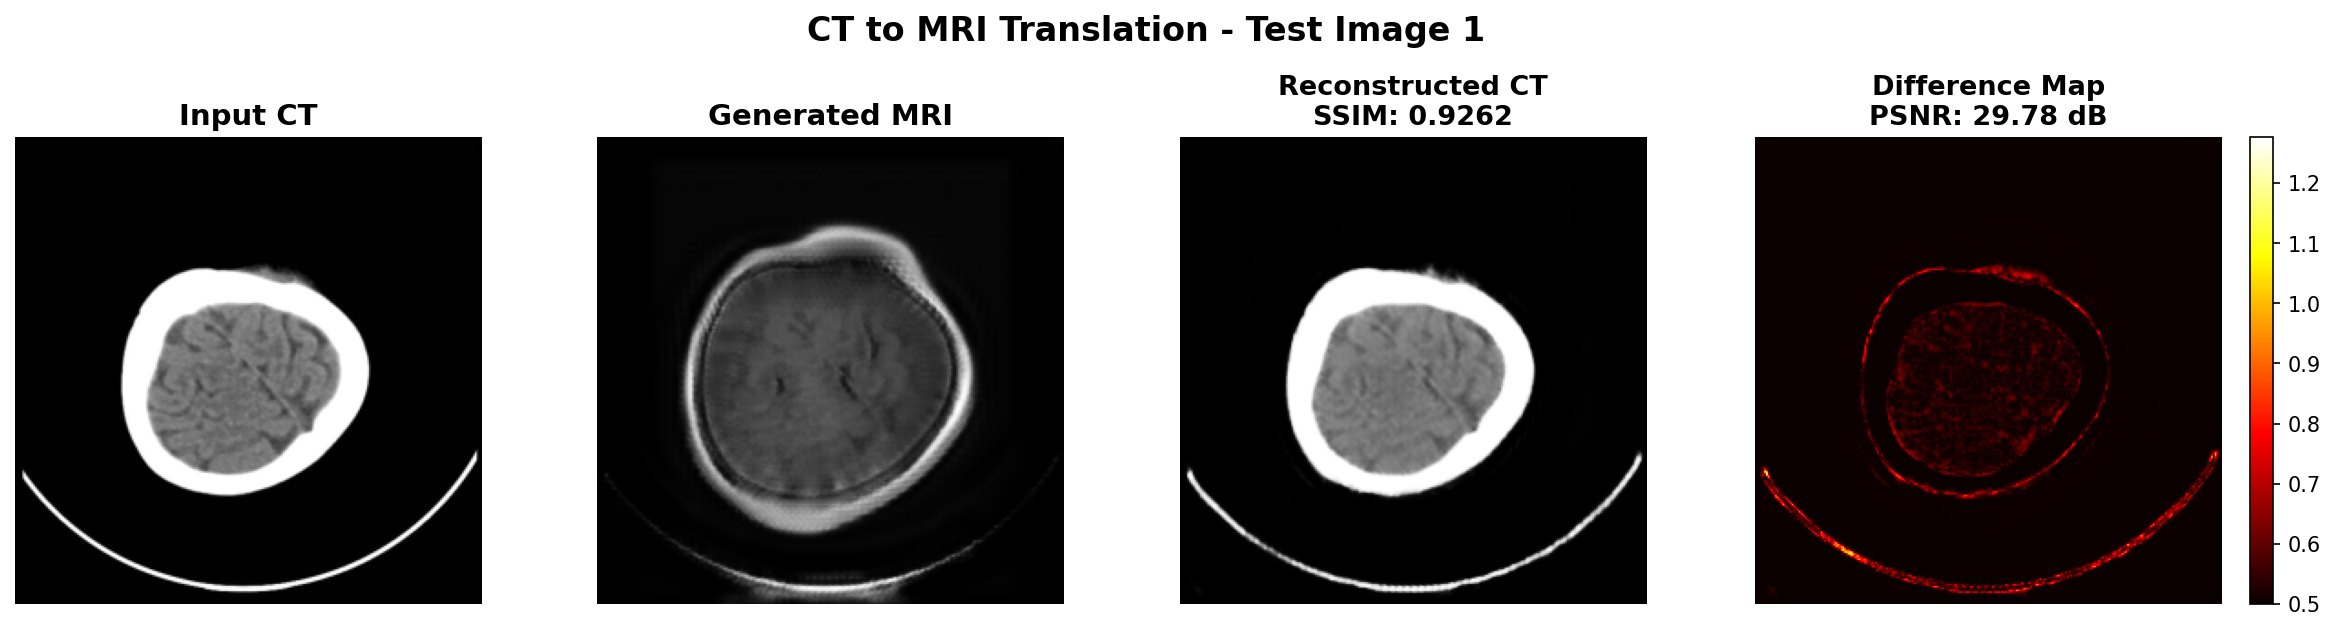


📸 CT_to_MRI_test2_ssim0.908_psnr32.6_124713.png


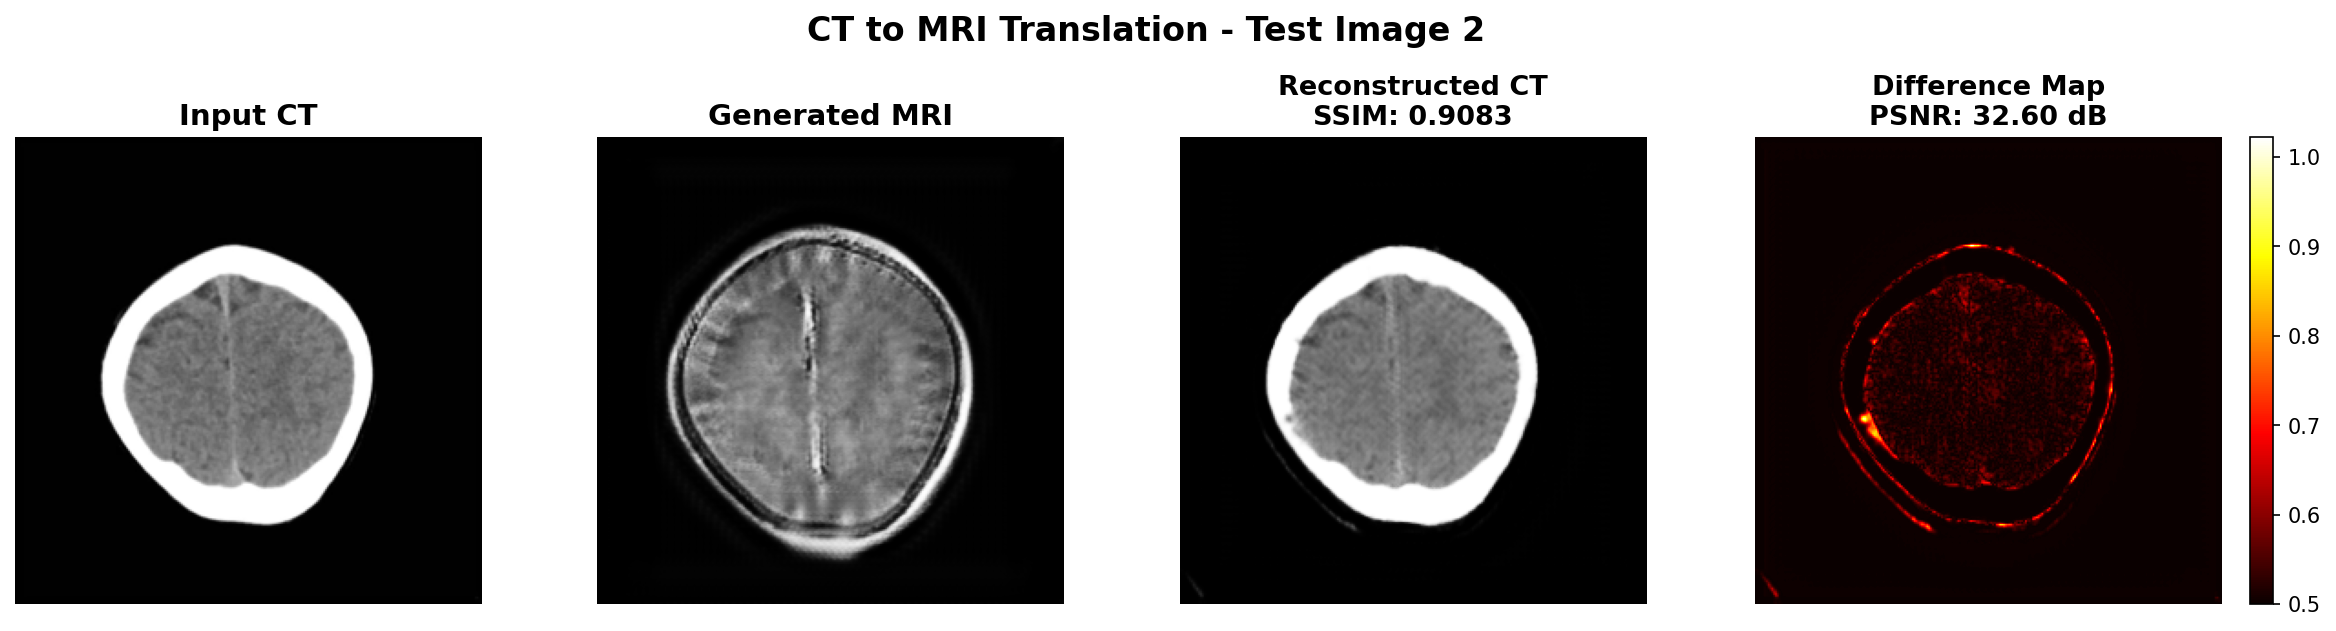


📸 MRI_to_CT_test1_ssim0.851_psnr29.0_124711.png


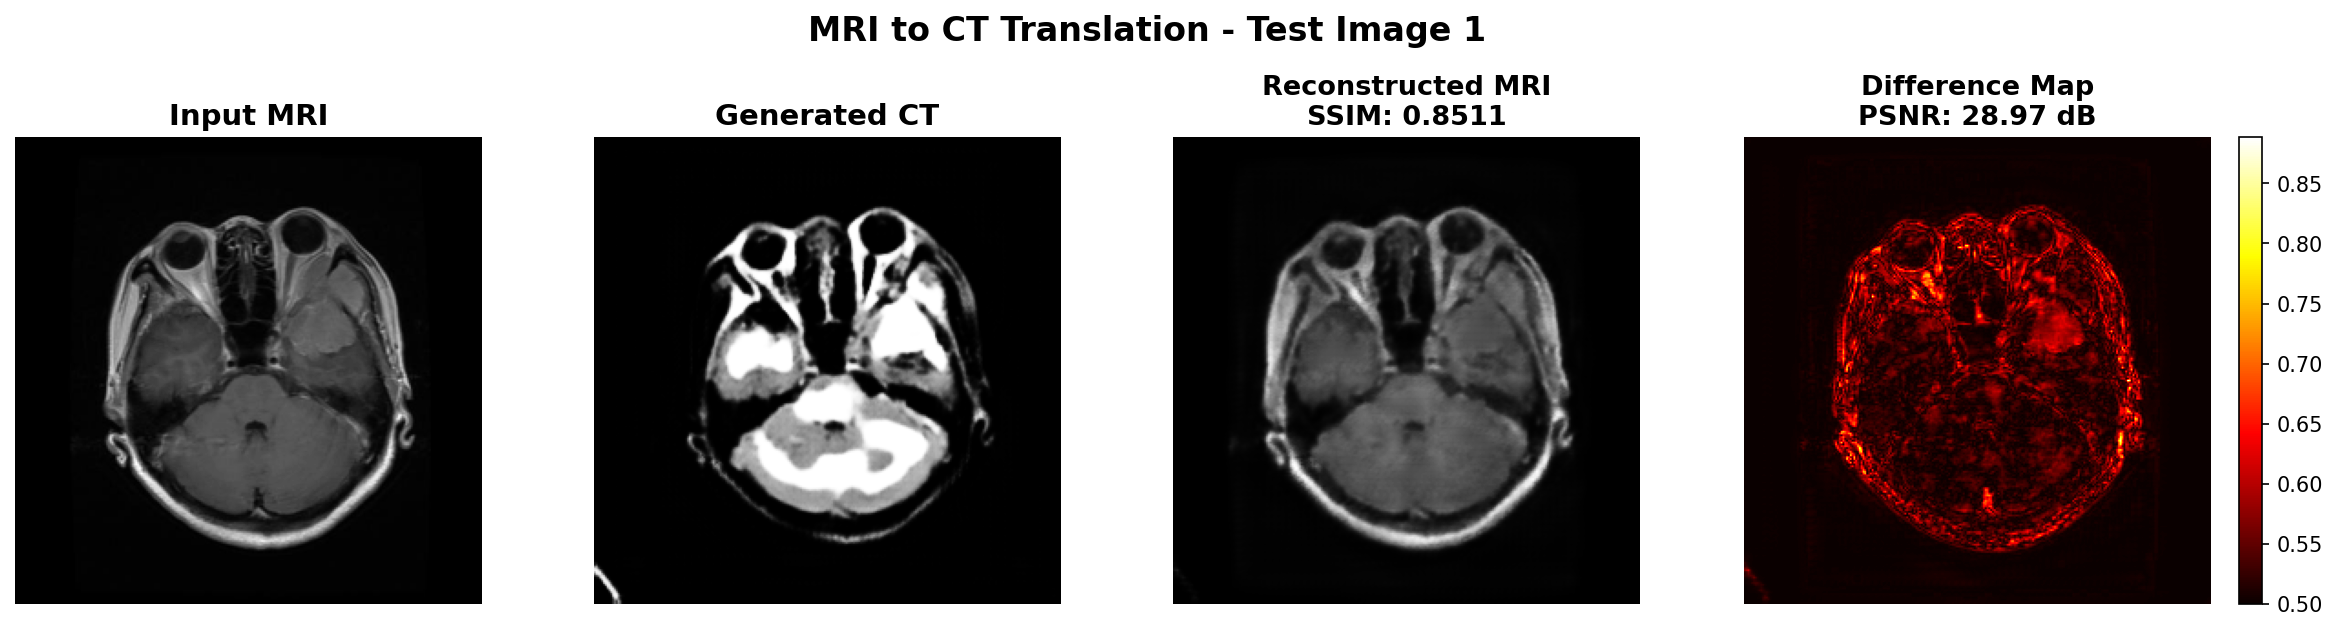


📸 MRI_to_CT_test2_ssim0.681_psnr24.2_124711.png


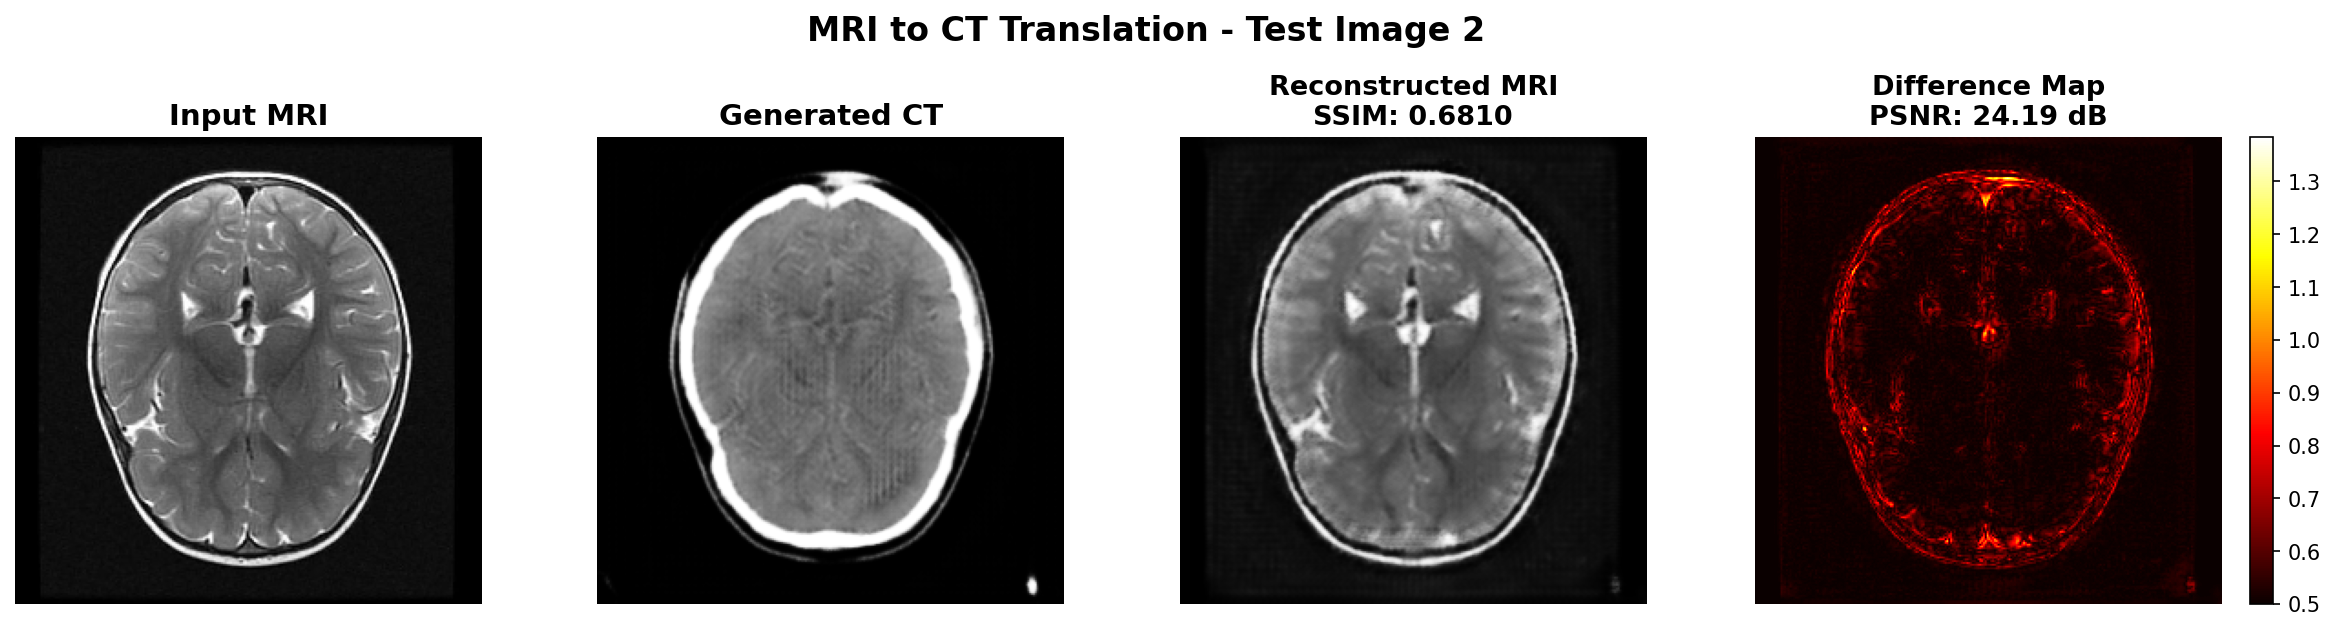


📊 Summary Report:


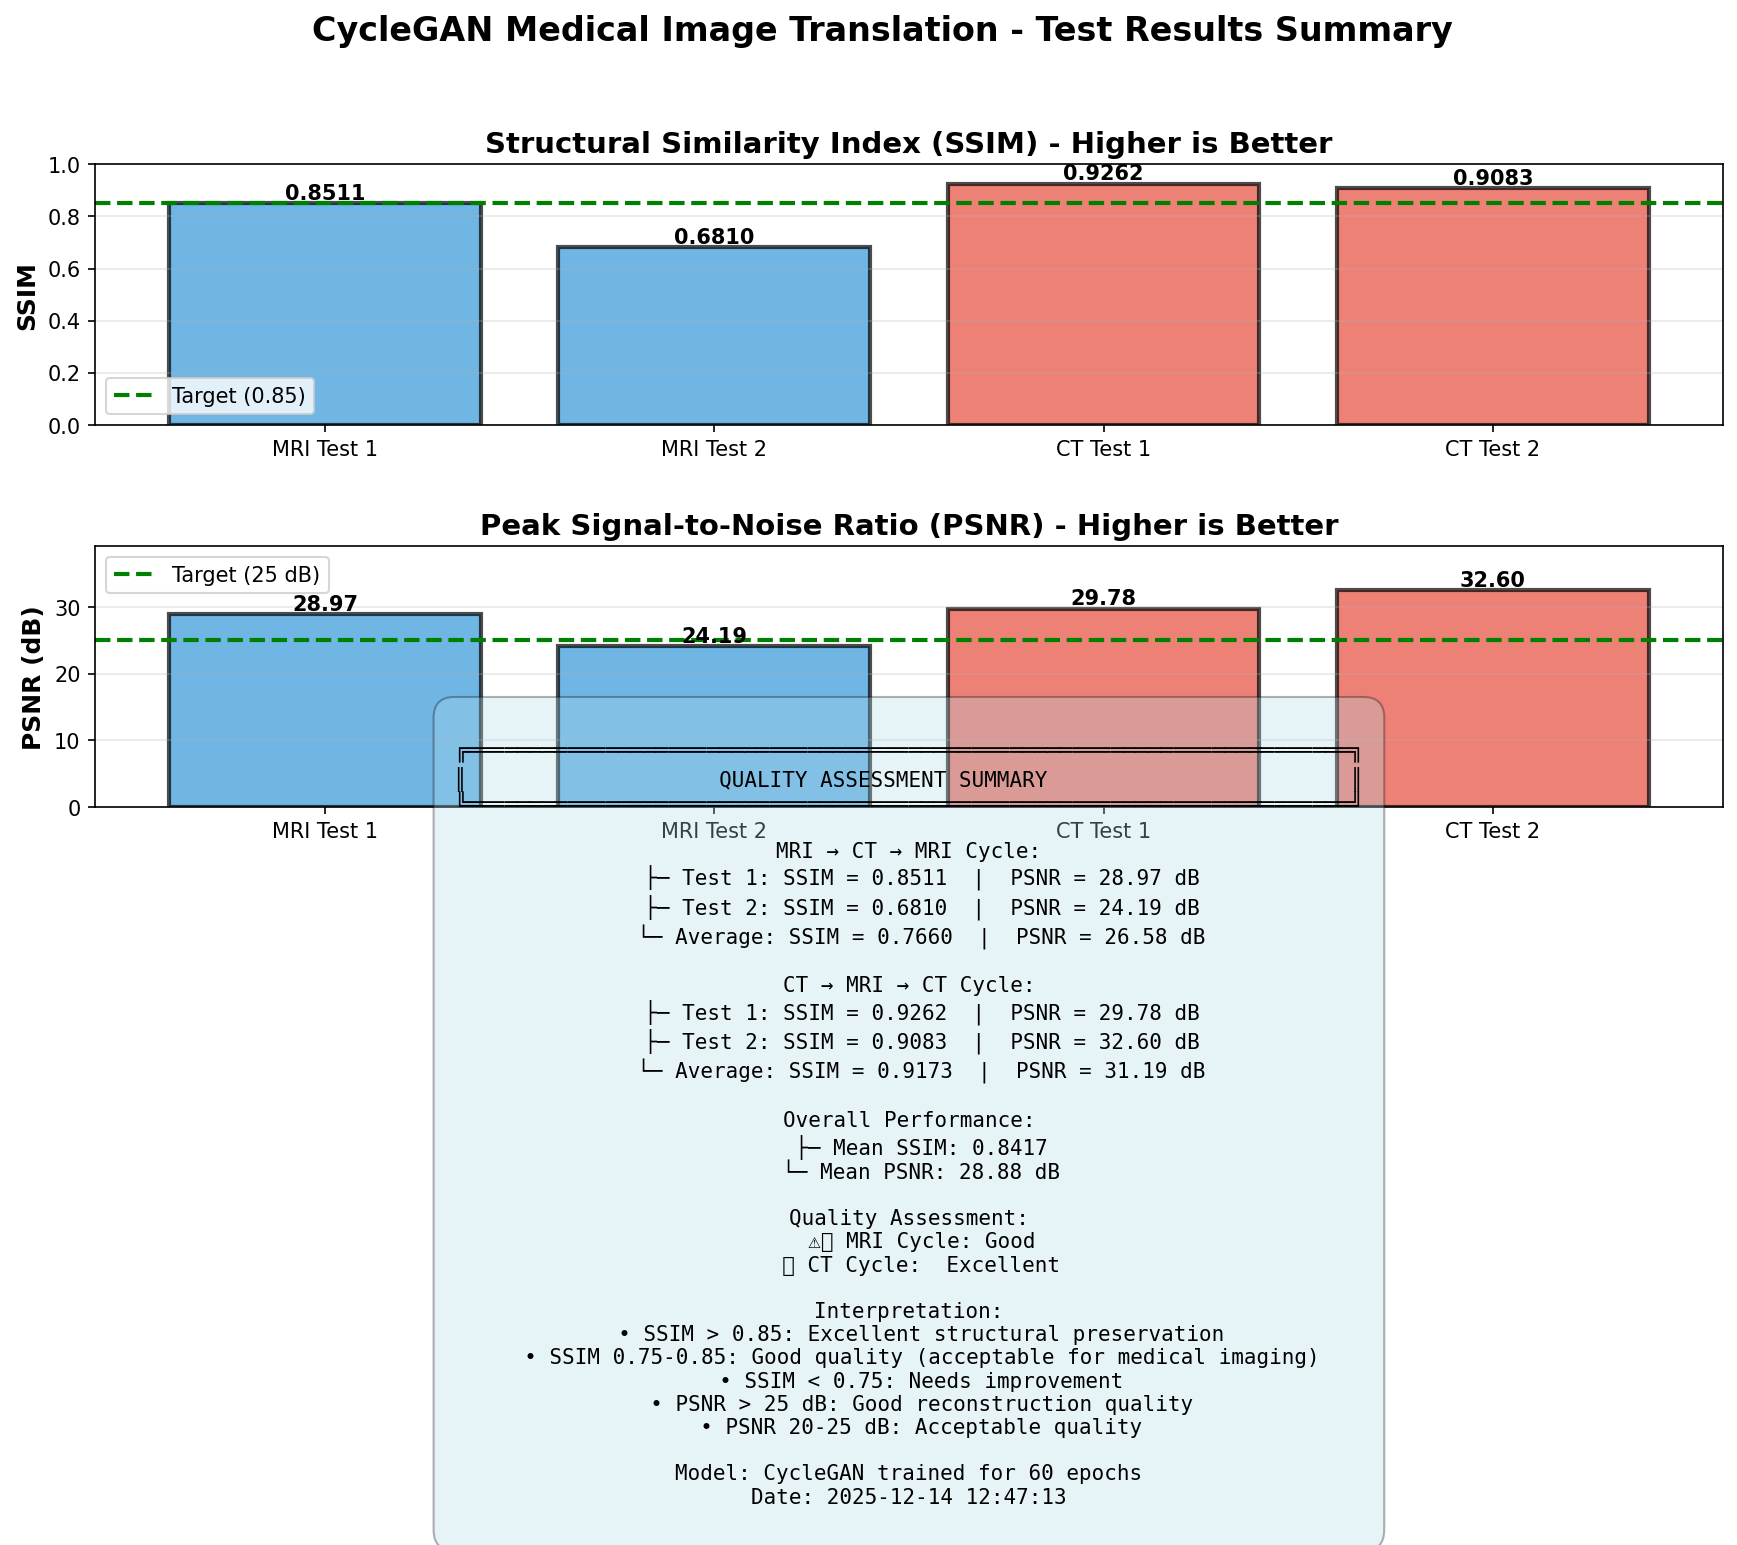


✅ TESTING COMPLETE!
Total images tested: 4 (2 MRI + 2 CT)
Total files saved: 5

Average SSIM: 0.8417
Average PSNR: 28.88 dB

All results saved in: ./results/


In [85]:
# Test 2 images per domain with detailed metrics
import os
import random
import matplotlib.pyplot as plt
import torch
from monai.metrics import SSIMMetric, PSNRMetric
from datetime import datetime

print("="*70)
print("🧪 TESTING 2 MRI + 2 CT IMAGES WITH QUALITY METRICS")
print("="*70)

# ============================================================================
# STEP 1: LOAD THE TRAINED MODEL
# ============================================================================

print("\n📦 Loading trained model from checkpoint...")

# Initialize model
test_model = CycleGAN(lr=0.0002, lambda_cycle=10.0, lambda_identity=0.5)

# Load the best model weights
best_model_path = "./checkpoints/best_model"
if os.path.exists(best_model_path):
    test_model.G_MRI_to_CT.load_state_dict(
        torch.load(f"{best_model_path}/G_MRI_to_CT.pth", map_location=device)
    )
    test_model.G_CT_to_MRI.load_state_dict(
        torch.load(f"{best_model_path}/G_CT_to_MRI.pth", map_location=device)
    )
    print(f"✓ Loaded best model from {best_model_path}")
else:
    # Try loading from epoch 60
    epoch60_path = "./checkpoints/epoch_60"
    if os.path.exists(epoch60_path):
        test_model.G_MRI_to_CT.load_state_dict(
            torch.load(f"{epoch60_path}/G_MRI_to_CT.pth", map_location=device)
        )
        test_model.G_CT_to_MRI.load_state_dict(
            torch.load(f"{epoch60_path}/G_CT_to_MRI.pth", map_location=device)
        )
        print(f"✓ Loaded model from {epoch60_path}")
    else:
        print("❌ No checkpoint found! Please check ./checkpoints/ directory")
        print("Available checkpoints:")
        if os.path.exists("./checkpoints"):
            print(os.listdir("./checkpoints"))
        raise FileNotFoundError("Model checkpoint not found")

# ============================================================================
# STEP 2: PREPARE DATASET PATHS
# ============================================================================

# Dataset paths
MRI_TEST_PATH = "/kaggle/input/ct-to-mri-cgan/Dataset/images/testB"
CT_TEST_PATH = "/kaggle/input/ct-to-mri-cgan/Dataset/images/testA"

# Verify paths exist
if not os.path.exists(MRI_TEST_PATH):
    print(f"❌ MRI test path not found: {MRI_TEST_PATH}")
    raise FileNotFoundError("MRI test path not found")

if not os.path.exists(CT_TEST_PATH):
    print(f"❌ CT test path not found: {CT_TEST_PATH}")
    raise FileNotFoundError("CT test path not found")

# Get test images
mri_images = [f for f in os.listdir(MRI_TEST_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]
ct_images = [f for f in os.listdir(CT_TEST_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]

if len(mri_images) < 2:
    print(f"❌ Need at least 2 MRI images, found {len(mri_images)}")
    raise ValueError("Not enough MRI test images")

if len(ct_images) < 2:
    print(f"❌ Need at least 2 CT images, found {len(ct_images)}")
    raise ValueError("Not enough CT test images")

print(f"✓ Found {len(mri_images)} MRI test images")
print(f"✓ Found {len(ct_images)} CT test images")

# Select 2 random images from each domain
selected_mris = random.sample(mri_images, 2)
selected_cts = random.sample(ct_images, 2)

print(f"\n📸 Selected MRI images:")
for i, mri in enumerate(selected_mris, 1):
    print(f"   {i}. {mri}")

print(f"\n📸 Selected CT images:")
for i, ct in enumerate(selected_cts, 1):
    print(f"   {i}. {ct}")

# ============================================================================
# STEP 3: INITIALIZE METRICS AND TRANSFORMS
# ============================================================================

# Initialize metrics
ssim_metric = SSIMMetric(spatial_dims=2)
psnr_metric = PSNRMetric(max_val=2.0)

# Transforms
mri_transform = get_transforms(mode="val", modality="mri", target_size=(256, 256))
ct_transform = get_transforms(mode="val", modality="ct", target_size=(256, 256))

# Set model to eval mode
test_model.G_MRI_to_CT.eval()
test_model.G_CT_to_MRI.eval()

# ============================================================================
# STEP 4: HELPER FUNCTIONS
# ============================================================================

def to_display(img):
    """Convert tensor to displayable numpy array"""
    return (img.cpu().numpy()[0, 0] + 1) / 2

def calculate_metrics(original, reconstructed):
    """Calculate SSIM and PSNR"""
    ssim = ssim_metric(reconstructed, original).mean().item()
    psnr = psnr_metric(reconstructed, original).mean().item()
    return ssim, psnr

# Store results for summary
all_results = []

# ============================================================================
# STEP 5: PROCESS MRI IMAGES
# ============================================================================

print("\n" + "="*70)
print("PROCESSING MRI → CT → MRI")
print("="*70)

for idx, mri_file in enumerate(selected_mris, 1):
    print(f"\n[{idx}/2] Processing {mri_file}...")
    
    # Load image
    mri_path = os.path.join(MRI_TEST_PATH, mri_file)
    mri_img = mri_transform(mri_path).unsqueeze(0).to(device)
    
    # Generate translations
    with torch.no_grad():
        fake_ct = test_model.G_MRI_to_CT(mri_img)
        cycle_mri = test_model.G_CT_to_MRI(fake_ct)
    
    # Calculate metrics
    ssim, psnr = calculate_metrics(mri_img, cycle_mri)
    print(f"   ✓ SSIM: {ssim:.4f} | PSNR: {psnr:.2f} dB")
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Real MRI
    axes[0].imshow(to_display(mri_img), cmap='gray')
    axes[0].set_title("Input MRI", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Generated CT
    axes[1].imshow(to_display(fake_ct), cmap='gray')
    axes[1].set_title("Generated CT", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Reconstructed MRI
    axes[2].imshow(to_display(cycle_mri), cmap='gray')
    axes[2].set_title(f"Reconstructed MRI\nSSIM: {ssim:.4f}", 
                     fontsize=13, fontweight='bold')
    axes[2].axis('off')
    
    # Difference map
    diff = torch.abs(cycle_mri - mri_img)
    im = axes[3].imshow(to_display(diff), cmap='hot')
    axes[3].set_title(f"Difference Map\nPSNR: {psnr:.2f} dB", 
                     fontsize=13, fontweight='bold')
    axes[3].axis('off')
    plt.colorbar(im, ax=axes[3], fraction=0.046)
    
    # Add overall title
    fig.suptitle(f"MRI to CT Translation - Test Image {idx}", 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save with meaningful filename
    timestamp = datetime.now().strftime("%H%M%S")
    save_name = f"./results/MRI_to_CT_test{idx}_ssim{ssim:.3f}_psnr{psnr:.1f}_{timestamp}.png"
    plt.savefig(save_name, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"   💾 Saved: {os.path.basename(save_name)}")
    
    # Store results
    all_results.append({
        'type': 'MRI→CT→MRI',
        'image': mri_file,
        'ssim': ssim,
        'psnr': psnr
    })

# ============================================================================
# STEP 6: PROCESS CT IMAGES
# ============================================================================

print("\n" + "="*70)
print("PROCESSING CT → MRI → CT")
print("="*70)

for idx, ct_file in enumerate(selected_cts, 1):
    print(f"\n[{idx}/2] Processing {ct_file}...")
    
    # Load image
    ct_path = os.path.join(CT_TEST_PATH, ct_file)
    ct_img = ct_transform(ct_path).unsqueeze(0).to(device)
    
    # Generate translations
    with torch.no_grad():
        fake_mri = test_model.G_CT_to_MRI(ct_img)
        cycle_ct = test_model.G_MRI_to_CT(fake_mri)
    
    # Calculate metrics
    ssim, psnr = calculate_metrics(ct_img, cycle_ct)
    print(f"   ✓ SSIM: {ssim:.4f} | PSNR: {psnr:.2f} dB")
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Real CT
    axes[0].imshow(to_display(ct_img), cmap='gray')
    axes[0].set_title("Input CT", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Generated MRI
    axes[1].imshow(to_display(fake_mri), cmap='gray')
    axes[1].set_title("Generated MRI", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Reconstructed CT
    axes[2].imshow(to_display(cycle_ct), cmap='gray')
    axes[2].set_title(f"Reconstructed CT\nSSIM: {ssim:.4f}", 
                     fontsize=13, fontweight='bold')
    axes[2].axis('off')
    
    # Difference map
    diff = torch.abs(cycle_ct - ct_img)
    im = axes[3].imshow(to_display(diff), cmap='hot')
    axes[3].set_title(f"Difference Map\nPSNR: {psnr:.2f} dB", 
                     fontsize=13, fontweight='bold')
    axes[3].axis('off')
    plt.colorbar(im, ax=axes[3], fraction=0.046)
    
    # Add overall title
    fig.suptitle(f"CT to MRI Translation - Test Image {idx}", 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save with meaningful filename
    timestamp = datetime.now().strftime("%H%M%S")
    save_name = f"./results/CT_to_MRI_test{idx}_ssim{ssim:.3f}_psnr{psnr:.1f}_{timestamp}.png"
    plt.savefig(save_name, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"   💾 Saved: {os.path.basename(save_name)}")
    
    # Store results
    all_results.append({
        'type': 'CT→MRI→CT',
        'image': ct_file,
        'ssim': ssim,
        'psnr': psnr
    })

# ============================================================================
# STEP 7: CREATE SUMMARY REPORT
# ============================================================================

print("\n" + "="*70)
print("CREATING SUMMARY REPORT")
print("="*70)

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1.5], hspace=0.4)

# Summary statistics
mri_results = [r for r in all_results if r['type'] == 'MRI→CT→MRI']
ct_results = [r for r in all_results if r['type'] == 'CT→MRI→CT']

avg_ssim_mri = sum(r['ssim'] for r in mri_results) / len(mri_results)
avg_psnr_mri = sum(r['psnr'] for r in mri_results) / len(mri_results)
avg_ssim_ct = sum(r['ssim'] for r in ct_results) / len(ct_results)
avg_psnr_ct = sum(r['psnr'] for r in ct_results) / len(ct_results)

# Plot 1: SSIM comparison
ax1 = fig.add_subplot(gs[0])
categories = ['MRI Test 1', 'MRI Test 2', 'CT Test 1', 'CT Test 2']
ssim_values = [r['ssim'] for r in all_results]
colors = ['#3498db', '#3498db', '#e74c3c', '#e74c3c']
bars1 = ax1.bar(categories, ssim_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=0.85, color='green', linestyle='--', linewidth=2, label='Target (0.85)')
ax1.set_ylabel('SSIM', fontsize=12, fontweight='bold')
ax1.set_title('Structural Similarity Index (SSIM) - Higher is Better', 
             fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars1, ssim_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: PSNR comparison
ax2 = fig.add_subplot(gs[1])
psnr_values = [r['psnr'] for r in all_results]
bars2 = ax2.bar(categories, psnr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=25, color='green', linestyle='--', linewidth=2, label='Target (25 dB)')
ax2.set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
ax2.set_title('Peak Signal-to-Noise Ratio (PSNR) - Higher is Better', 
             fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(psnr_values) * 1.2)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars2, psnr_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Summary table
ax3 = fig.add_subplot(gs[2])
ax3.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    QUALITY ASSESSMENT SUMMARY                        ║
╚══════════════════════════════════════════════════════════════════════╝

MRI → CT → MRI Cycle:
  ├─ Test 1: SSIM = {mri_results[0]['ssim']:.4f}  |  PSNR = {mri_results[0]['psnr']:.2f} dB
  ├─ Test 2: SSIM = {mri_results[1]['ssim']:.4f}  |  PSNR = {mri_results[1]['psnr']:.2f} dB
  └─ Average: SSIM = {avg_ssim_mri:.4f}  |  PSNR = {avg_psnr_mri:.2f} dB

CT → MRI → CT Cycle:
  ├─ Test 1: SSIM = {ct_results[0]['ssim']:.4f}  |  PSNR = {ct_results[0]['psnr']:.2f} dB
  ├─ Test 2: SSIM = {ct_results[1]['ssim']:.4f}  |  PSNR = {ct_results[1]['psnr']:.2f} dB
  └─ Average: SSIM = {avg_ssim_ct:.4f}  |  PSNR = {avg_psnr_ct:.2f} dB

Overall Performance:
  ├─ Mean SSIM: {(avg_ssim_mri + avg_ssim_ct)/2:.4f}
  └─ Mean PSNR: {(avg_psnr_mri + avg_psnr_ct)/2:.2f} dB

Quality Assessment:
  {'✅' if avg_ssim_mri > 0.85 else '⚠️'} MRI Cycle: {'Excellent' if avg_ssim_mri > 0.85 else 'Good' if avg_ssim_mri > 0.75 else 'Needs Improvement'}
  {'✅' if avg_ssim_ct > 0.85 else '⚠️'} CT Cycle:  {'Excellent' if avg_ssim_ct > 0.85 else 'Good' if avg_ssim_ct > 0.75 else 'Needs Improvement'}

Interpretation:
  • SSIM > 0.85: Excellent structural preservation
  • SSIM 0.75-0.85: Good quality (acceptable for medical imaging)
  • SSIM < 0.75: Needs improvement
  • PSNR > 25 dB: Good reconstruction quality
  • PSNR 20-25 dB: Acceptable quality

Model: CycleGAN trained for 60 epochs
Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

ax3.text(0.5, 0.5, summary_text, fontsize=10, family='monospace',
         ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))

fig.suptitle('CycleGAN Medical Image Translation - Test Results Summary', 
            fontsize=16, fontweight='bold', y=0.98)

# Save summary
summary_filename = f"./results/Test_Summary_Report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(summary_filename, dpi=150, bbox_inches='tight')
plt.close()

print(f"   💾 Saved summary: {os.path.basename(summary_filename)}")

# ============================================================================
# STEP 8: DISPLAY ALL RESULTS
# ============================================================================

print("\n" + "="*70)
print("📊 DISPLAYING ALL RESULTS")
print("="*70)

from IPython.display import Image as IPImage, display

# Show individual test results
result_files = sorted([f for f in os.listdir('./results/') 
                      if f.startswith(('MRI_to_CT_test', 'CT_to_MRI_test'))])

for result_file in result_files:
    print(f"\n📸 {result_file}")
    display(IPImage(filename=f"./results/{result_file}"))

# Show summary
print(f"\n📊 Summary Report:")
display(IPImage(filename=summary_filename))

# Print final statistics
print("\n" + "="*70)
print("✅ TESTING COMPLETE!")
print("="*70)
print(f"Total images tested: 4 (2 MRI + 2 CT)")
print(f"Total files saved: {len(result_files) + 1}")
print(f"\nAverage SSIM: {(avg_ssim_mri + avg_ssim_ct)/2:.4f}")
print(f"Average PSNR: {(avg_psnr_mri + avg_psnr_ct)/2:.2f} dB")
print("\nAll results saved in: ./results/")
print("="*70)